In [83]:
import SIMSIToolBox
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score, accuracy_score, mean_absolute_error
import random as rd
import seaborn as sb
import pandas as pd
from sklearn.linear_model import LinearRegression
from scipy import spatial
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from sklearn.svm import SVR
cosineSim = lambda x1,x2: 1 - spatial.distance.cosine(x1, x2)
import statsmodels.api as sm
from scipy.interpolate import interp1d
from sklearn.metrics import r2_score

In [23]:
#goal simulate labeling patterns

n=100
c13ab = 0.011 #natural abundance
N = [(1-c13ab)**2,2*(1-c13ab)*c13ab,c13ab**2] #get expected labeling of precursor from natural abundance
isa_func = SIMSIToolBox.palmitateISA

gs = np.random.random(n)
ds = np.random.random(n)
ts = np.random.random((n,3))
ts = np.array([x/np.sum(x) for x in ts])

In [24]:
labeling_theo = []
for g,t,d in zip(gs,ts,ds):
    labeling_theo.append(isa_func(g,d,t,N,None))
labeling_theo = np.array(labeling_theo)
T = [0,0,1]

In [72]:
plt_dict = {}

for noiseFrac in np.linspace(0,.5,15):
    for g,d,t,l_true in zip(gs,ds,ts,labeling_theo):
        x_true = d * np.array(t) + (1-d) * np.array(N)
        noise = np.random.random(l_true.shape)
        noise = noiseFrac * noise / np.sum(noise)
        l_obs = (1-noiseFrac) * l_true / np.sum(l_true)
        l_obs = [l+ns for l,ns in zip(l_obs,noise)]
        l_obs = np.array(l_obs)/np.sum(l_obs)
        
        #err_measure = np.sqrt(np.sum([np.square(x-y) for x,y in zip(l_obs,l_true)]))
        
        err_measure = np.sum([np.abs(x-y) for x,y in zip(l_obs,l_true)])
        #err_measure = cosineSim(l_obs,l_true)
        #err_measure = noiseFrac
        
        g_pred, _, x_pred, err, l_pred = SIMSIToolBox.ISAFit(T,N,l_obs,isa_func,list(range(len(l_obs))),.5)
        g_class, d_pred, _, err, l_pred = SIMSIToolBox.ISAFit_classical(t,N,l_obs,isa_func,list(range(len(l_obs))),np.array([.5,.5]))

        x_pred_classical = d_pred * np.array(t) + (1-d_pred) * np.array(N)
        
        err_x = np.sum(np.abs(x_true-x_pred))
        err_x_classical = np.abs(sum(x_true-x_pred_classical))
        
        if g_pred > -.0001 and g_pred < 1.1 and all(xx > -0.01 and xx < 1.1 for xx in x_pred) and g_class > -.0001 and g_class < 1.1:
            plt_dict[len(plt_dict)] = {"method":"SISA","error in g(t)":np.abs(g-g_pred),"measurement error":err_measure,"error in acetyl-CoA":err_x}
            plt_dict[len(plt_dict)] = {"method":"Classical ISA","error in g(t)":np.abs(g-g_class),"measurement error":err_measure,"error in acetyl-CoA":err_x_classical}
plt_dict = pd.DataFrame.from_dict(plt_dict,orient="index")
plt_dict

,method,error in g(t),measurement error,error in acetyl-CoA
0,SISA,0.000005,2.173979e-16,9.452090e-06
1,Classical ISA,0.000004,2.173979e-16,3.469447e-17
2,SISA,0.000008,3.067895e-16,2.262090e-05
3,Classical ISA,0.000003,3.067895e-16,1.249001e-16
4,SISA,0.000160,2.564896e-16,1.883675e-01
...,...,...,...,...
2983,Classical ISA,0.046689,4.145364e-01,8.326673e-17
2984,SISA,0.243395,6.103886e-01,1.915538e-01
2985,Classical ISA,0.239161,6.103886e-01,5.551115e-17
2986,SISA,0.213756,5.476561e-01,2.128465e-01


error in g(t) 0.3089628738163782
error in acetyl-CoA 0.2775754199563518


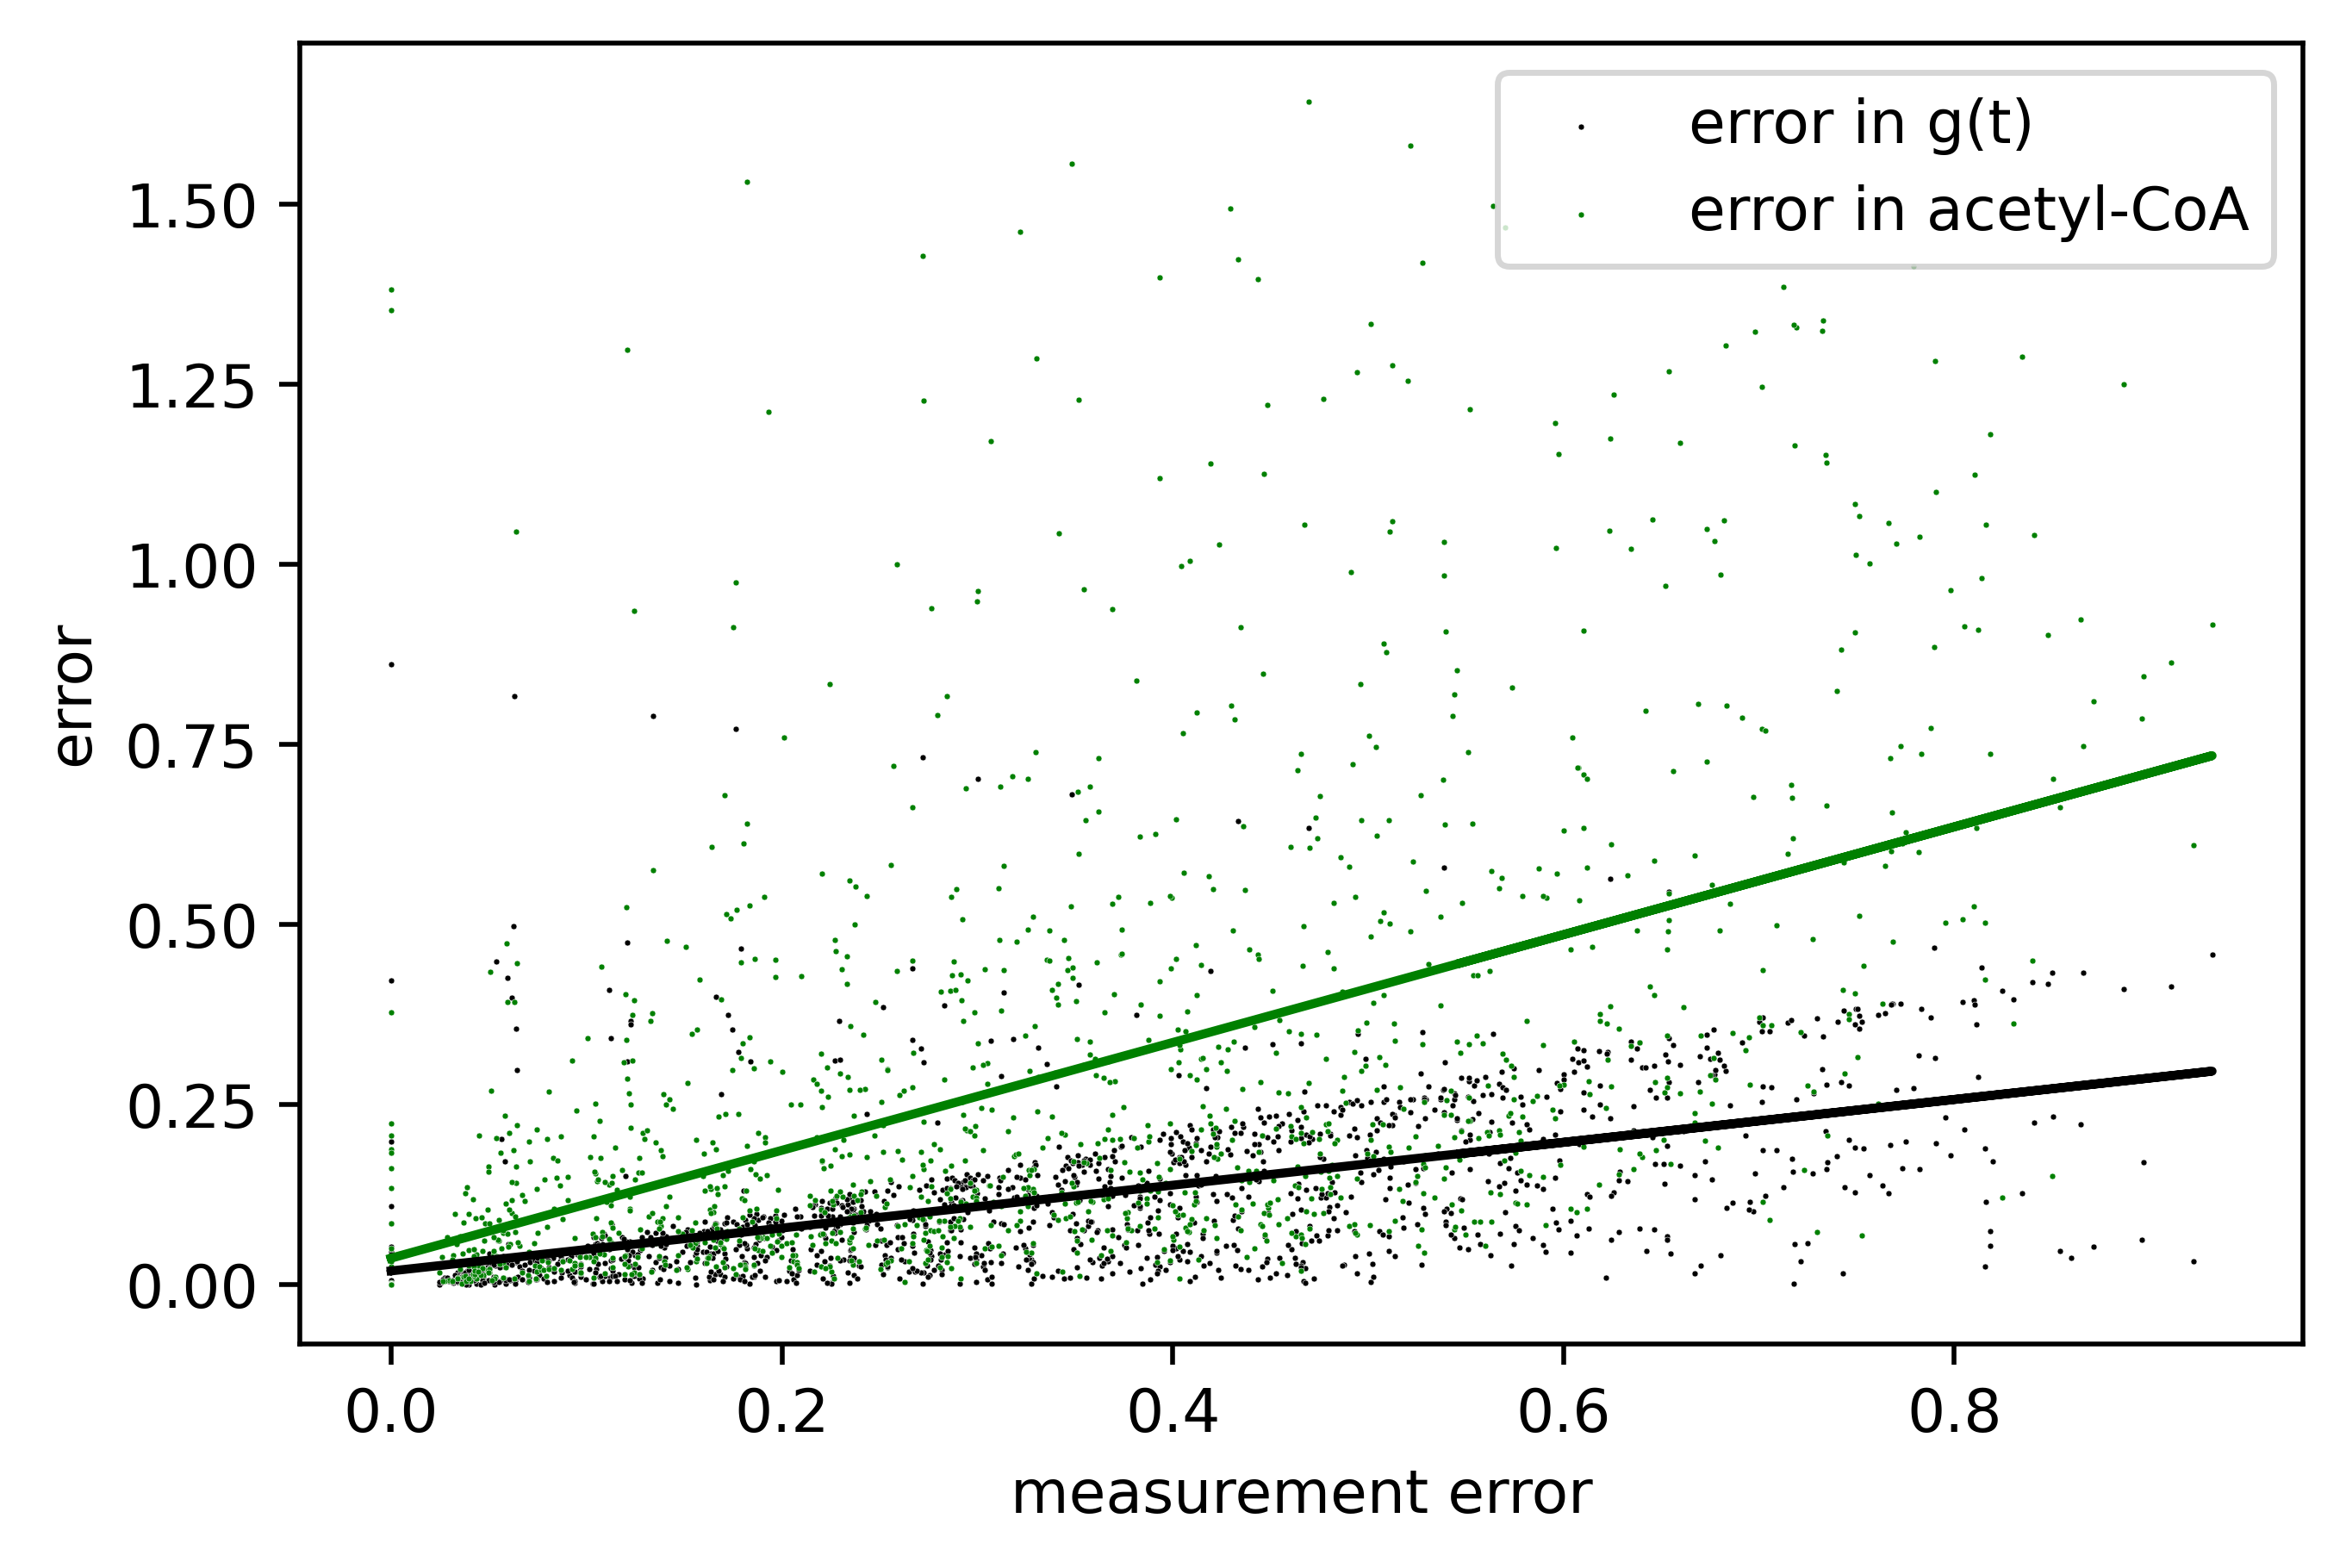

In [93]:
palette = {"error in g(t)":"black","error in acetyl-CoA":"green"}
models = {}
#sb.lineplot(data=plt_dict,x="measurement error",y="error in g(t)",hue="method",palette=palette)
for error,color in palette.items():
    filt = plt_dict[plt_dict["method"] == "SISA"]
    #sb.regplot(data=filt,x="measurement error",y=error, ci=0,scatter_kws={"s": .1,"alpha":1.0},color=color,label=error)
    sb.scatterplot(data=filt,x="measurement error",y=error, s = 1,alpha=1.0,color=color,label=error)
    linReg = LinearRegression()
    linReg.fit(filt["measurement error"].values.reshape(-1,1),filt[error].values)
    z = lowess(filt[error].values, filt["measurement error"].values,is_sorted=False)
    #pred = interp1d(z[:,0],z[:,1])(filt["measurement error"].values)
    pred = linReg.predict(filt["measurement error"].values.reshape(-1,1))
    r2 = r2_score(filt[error].values,pred)
    plt.plot(filt["measurement error"].values,pred,color=color)
    models[error] = interp1d(filt["measurement error"].values,pred,fill_value="extrapolate")
    print(error,r2)
    
plt.ylabel("error")
plt.legend()


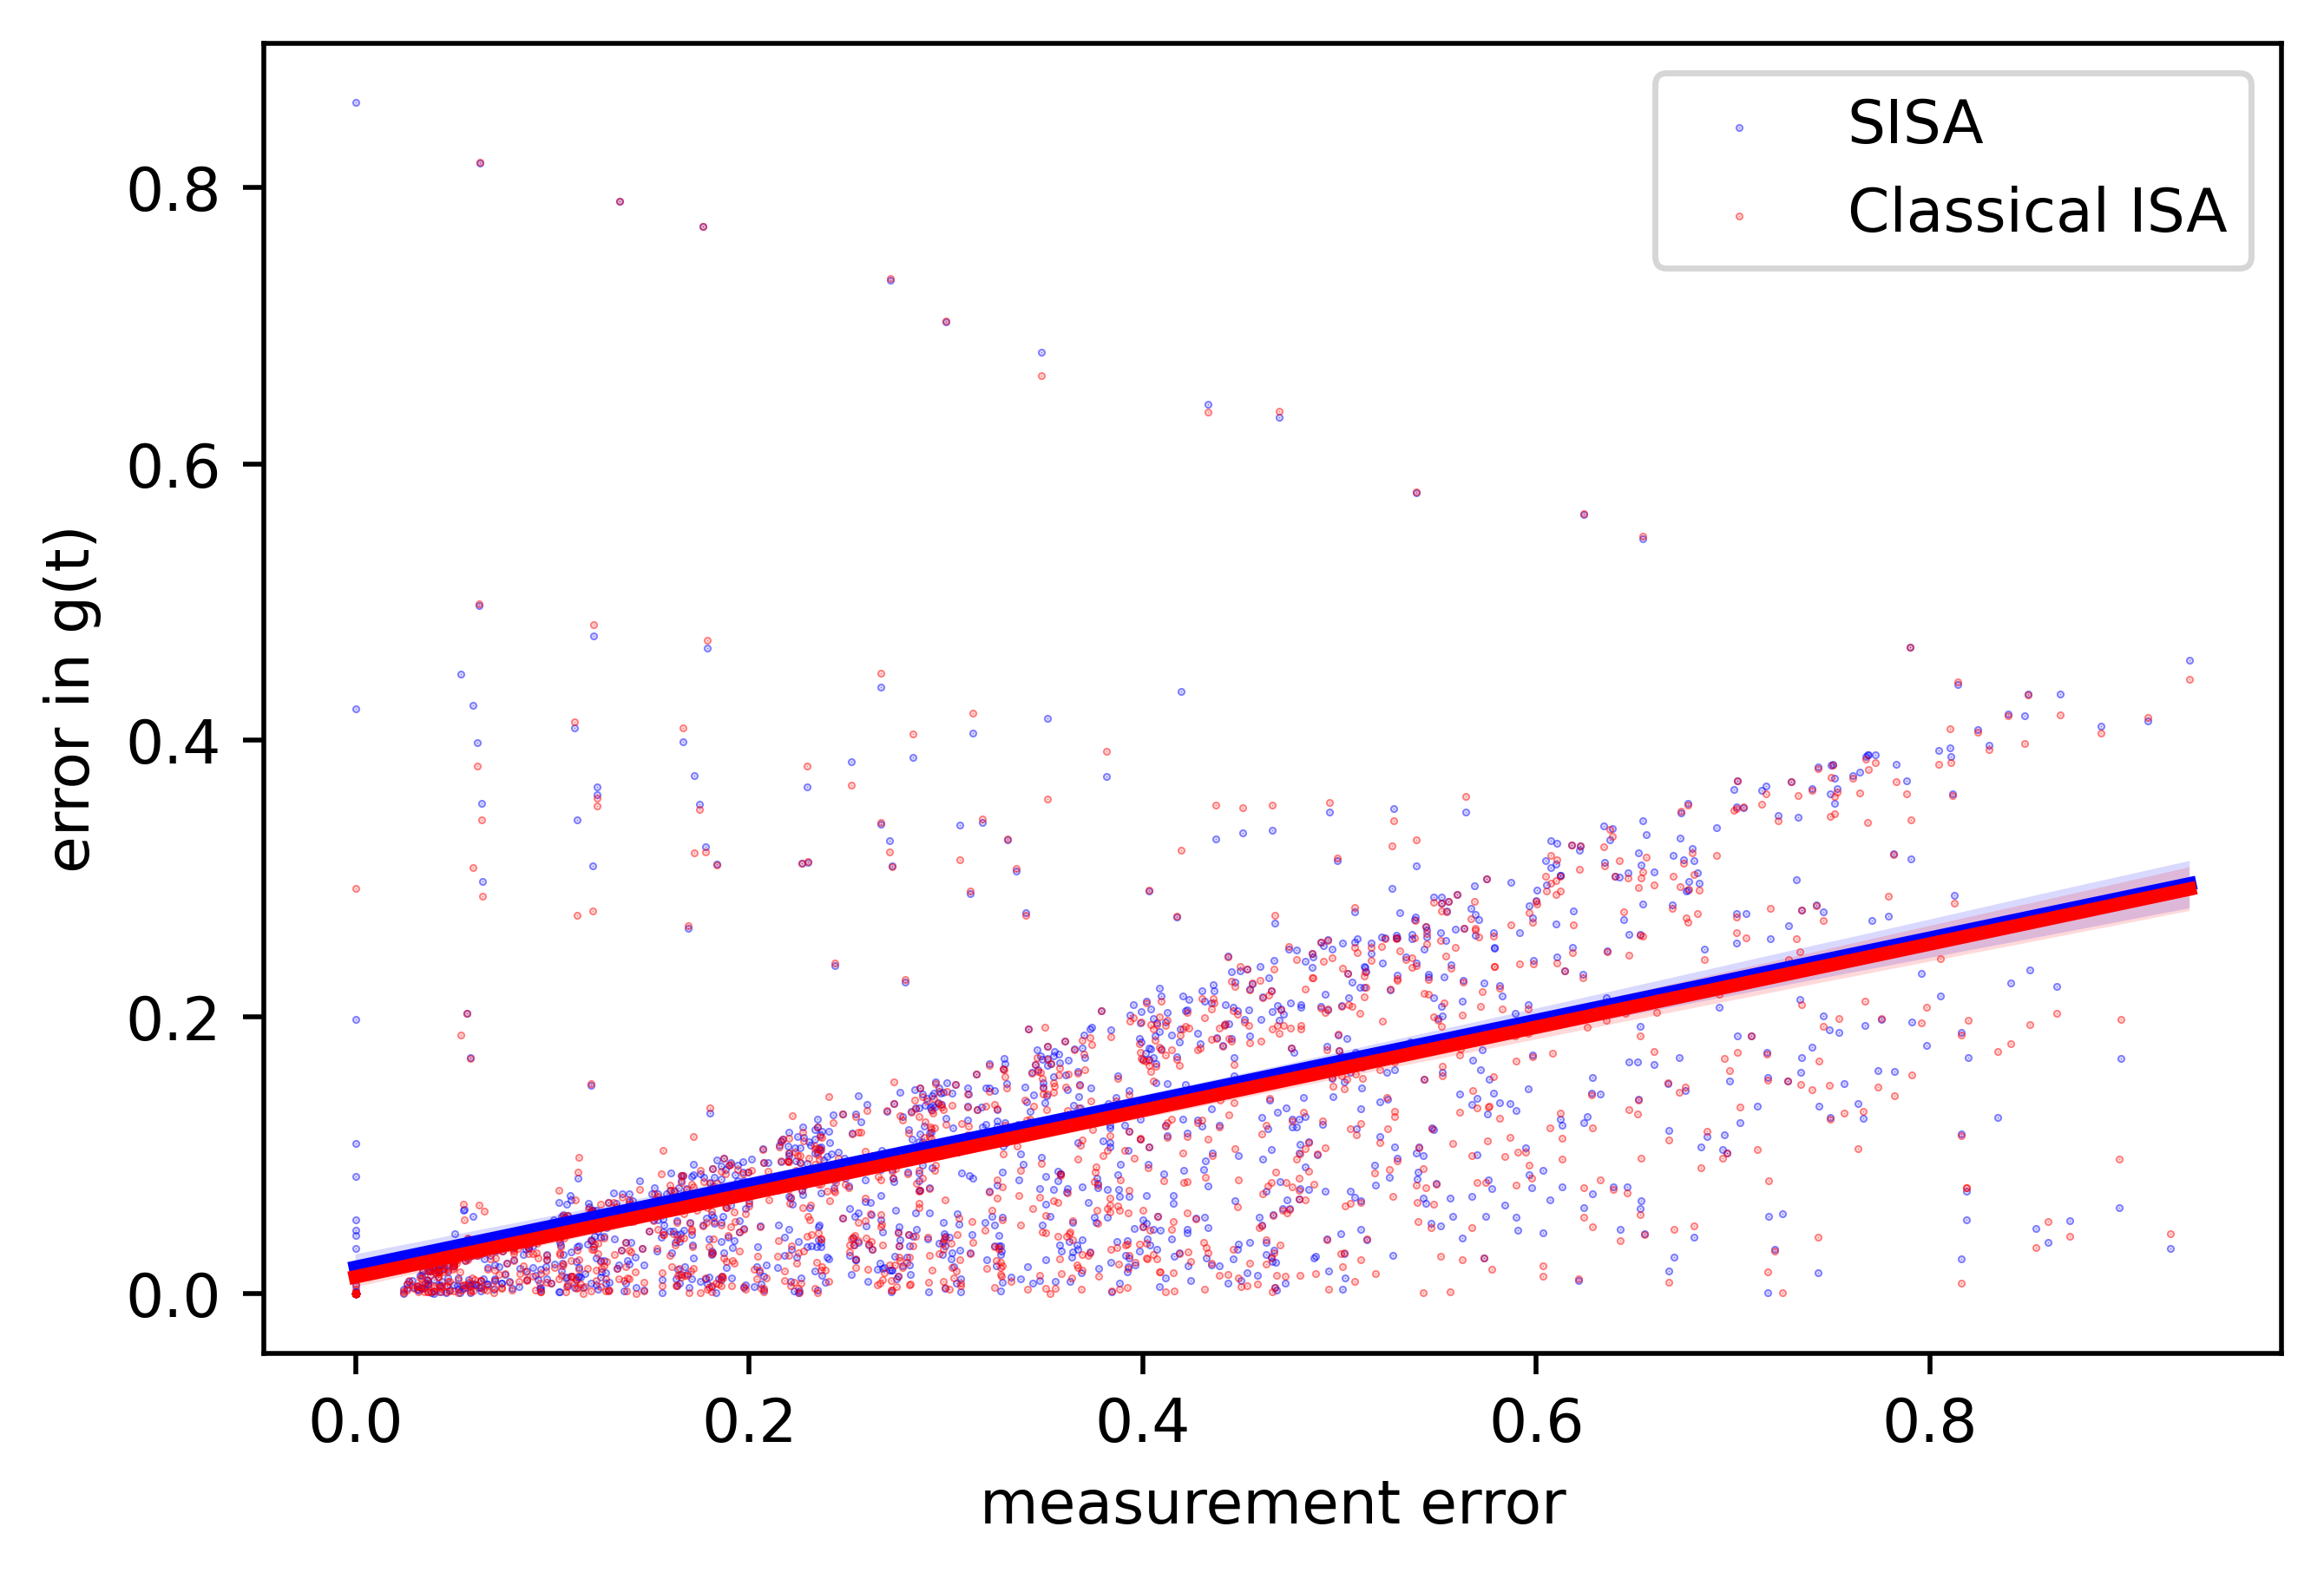

In [95]:
palette = {"SISA":"blue","Classical ISA":"red"}
#models = {}
#sb.lineplot(data=plt_dict,x="measurement error",y="error in g(t)",hue="method",palette=palette)
for method,color in palette.items():
    filt = plt_dict[plt_dict["method"] == method]
    sb.regplot(data=plt_dict[plt_dict["method"] == method],x="measurement error",y="error in g(t)",ci=95,scatter_kws={"s": .1,"alpha":0.5},color=color,label=method)
    linReg = LinearRegression()
    linReg.fit(filt["measurement error"].values.reshape(-1,1),filt["error in g(t)"].values)
    pred = linReg.predict(filt["measurement error"].values.reshape(-1,1))
    plt.plot(filt["measurement error"].values,pred,color=color)
    #lowess = sm.nonparametric.lowess
    #z = lowess(filt["error in g(t)"].values, filt["measurement error"].values,is_sorted=False)
    #models[method] = interp1d(z[:,0],z[:,1])

plt.legend()
#plt.plot(errToTest,errToTest,alpha=0.5,color="grey",linestyle=":")

In [51]:
formula = "C16H31O2" 
polarity="negative"
num_cores=10
ppmThresh = 50
datadir = "X:/MSI_Shared_Data/13CImagingManuscript/raw_data/imzmls/subset_data/"
file = "20201027_01_110w170h_12CnontumorLiver7_02116B_01 02116B_1.csv"
m0Mz,mzsOI,numCarbons = SIMSIToolBox.getMzsOfIsotopologues(formula,elementOfInterest="C")
msi = SIMSIToolBox.MSIData(mzsOI,ppm=ppmThresh,numCores = num_cores,intensityCutoff=0)
df = pd.read_csv(datadir + file,index_col=0)
msi.from_pandas(df,polarity)

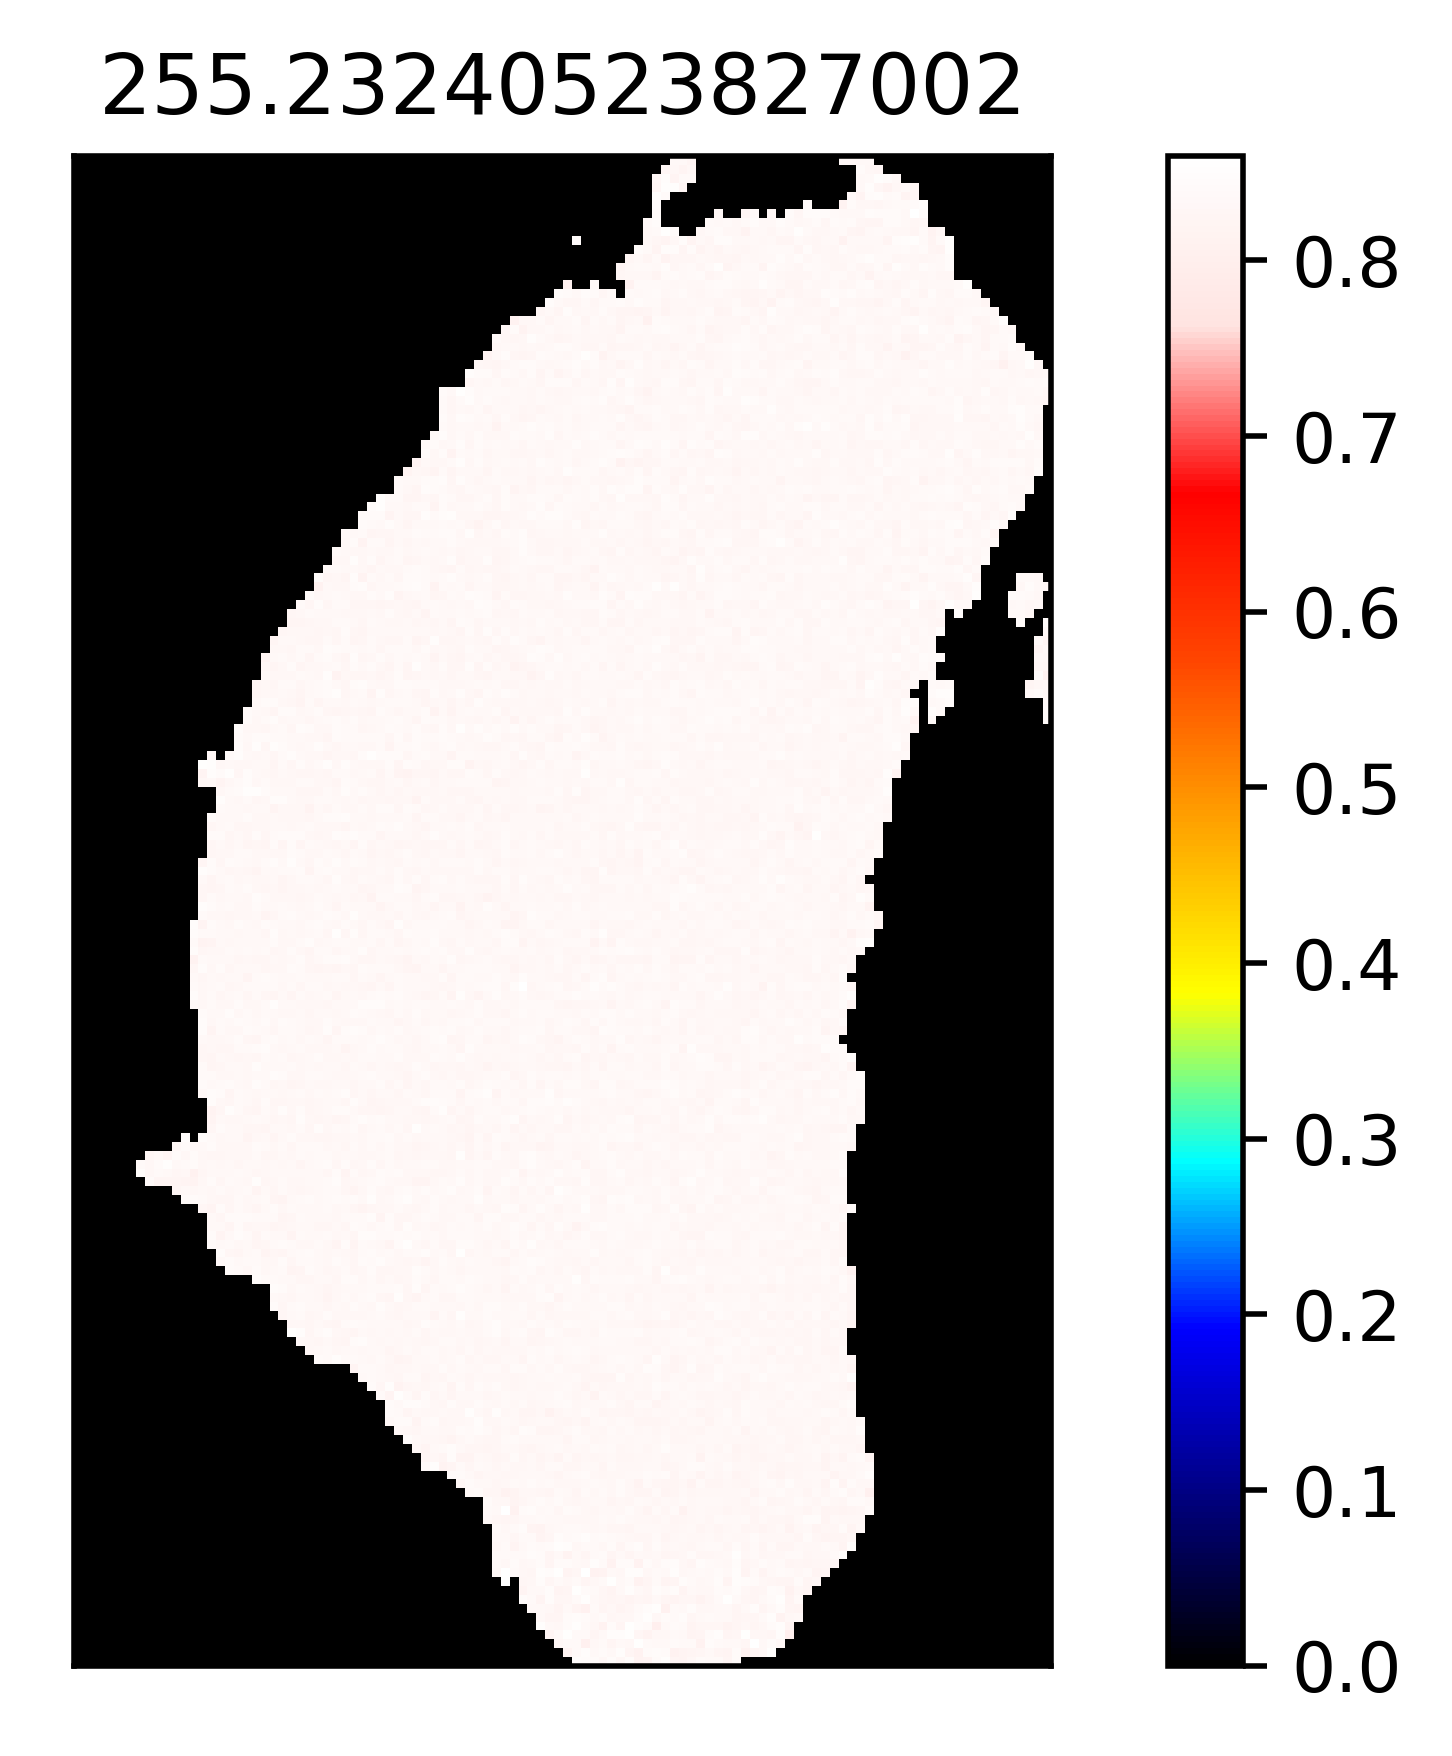

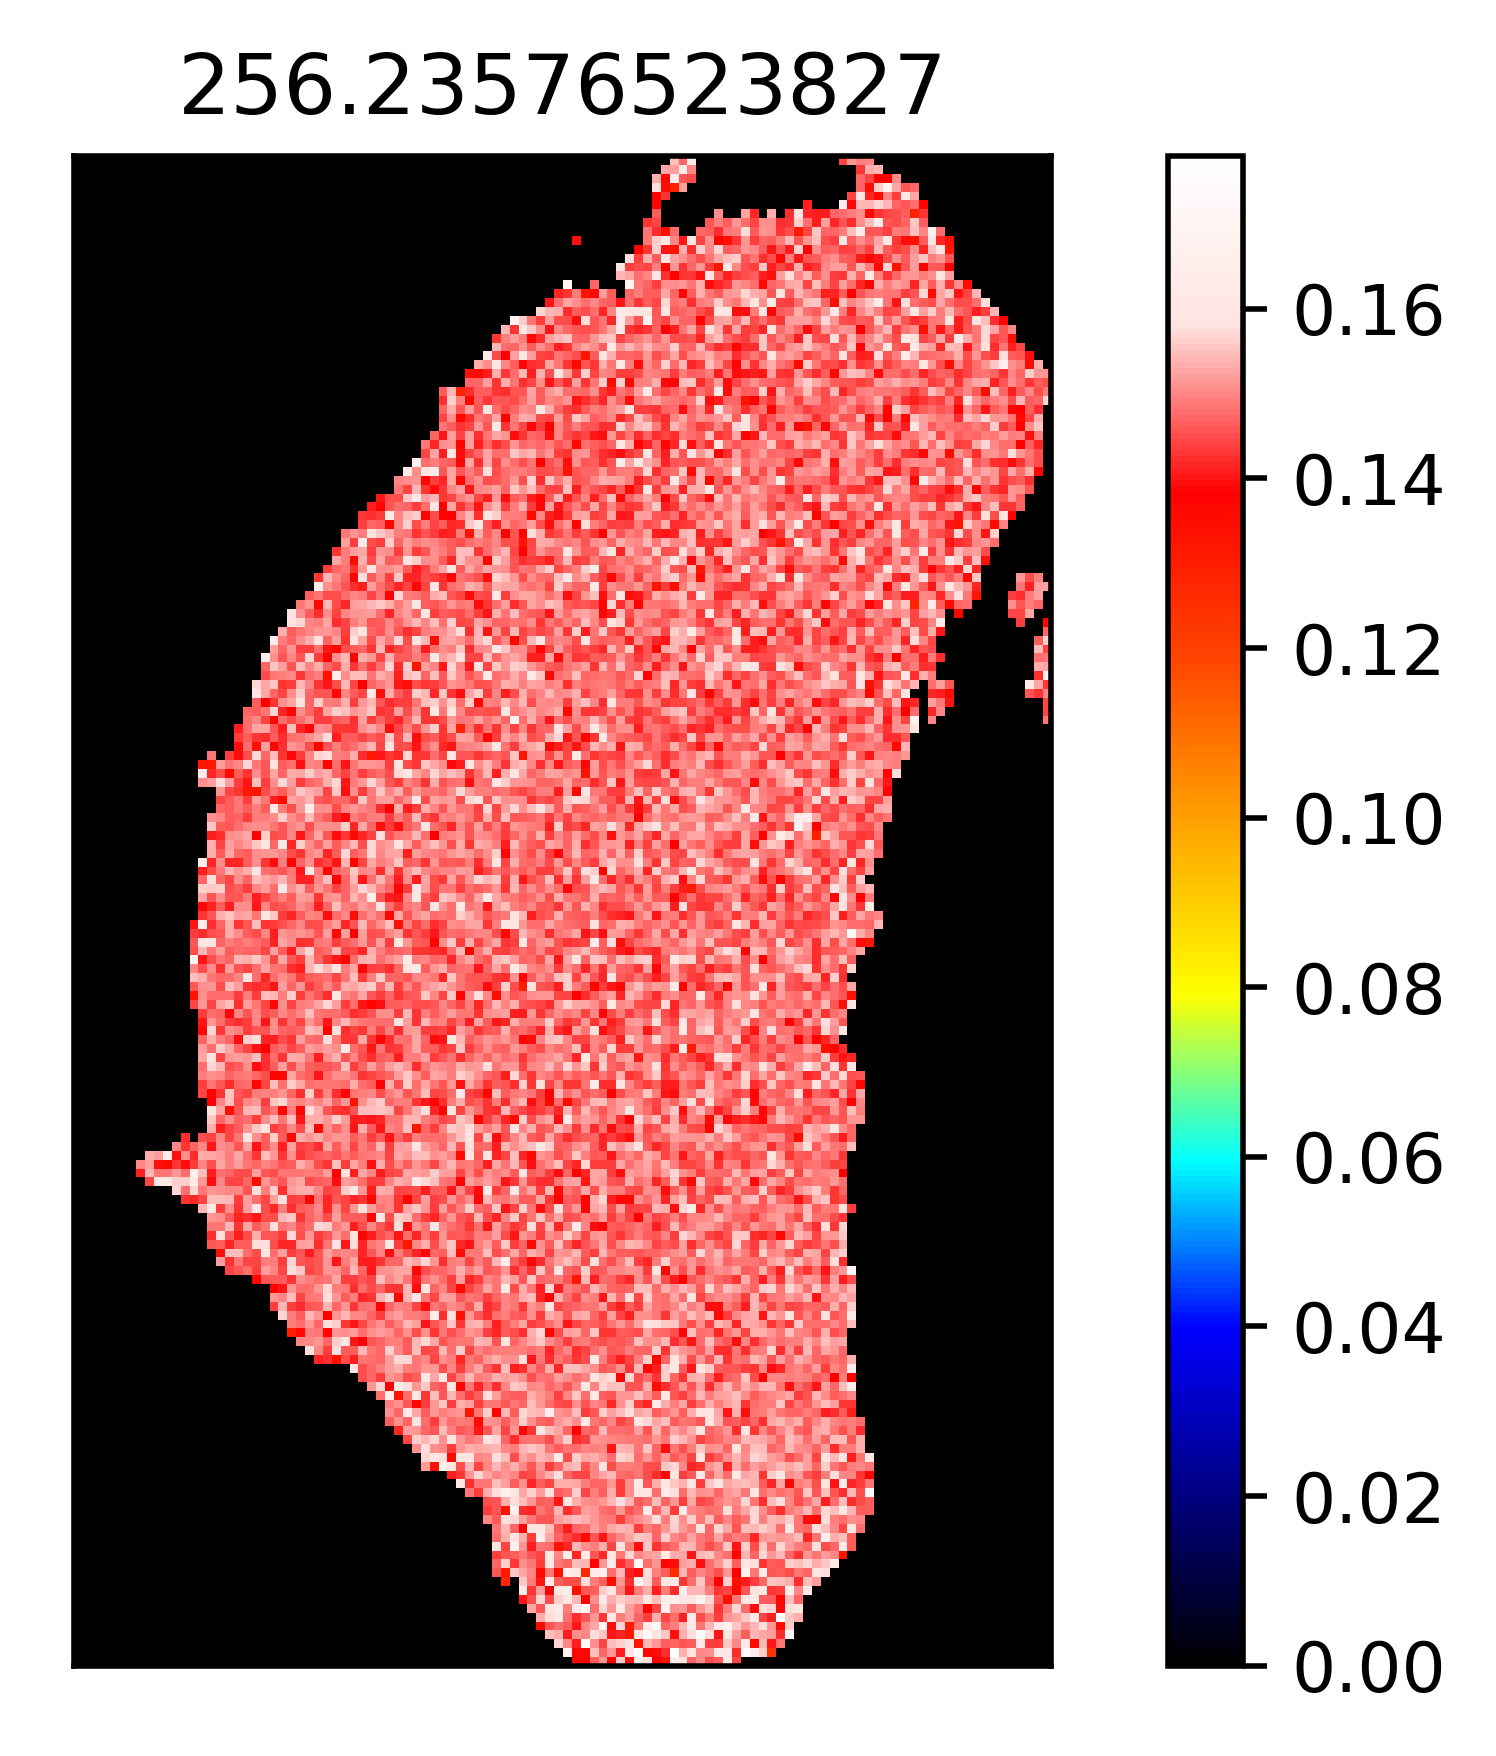

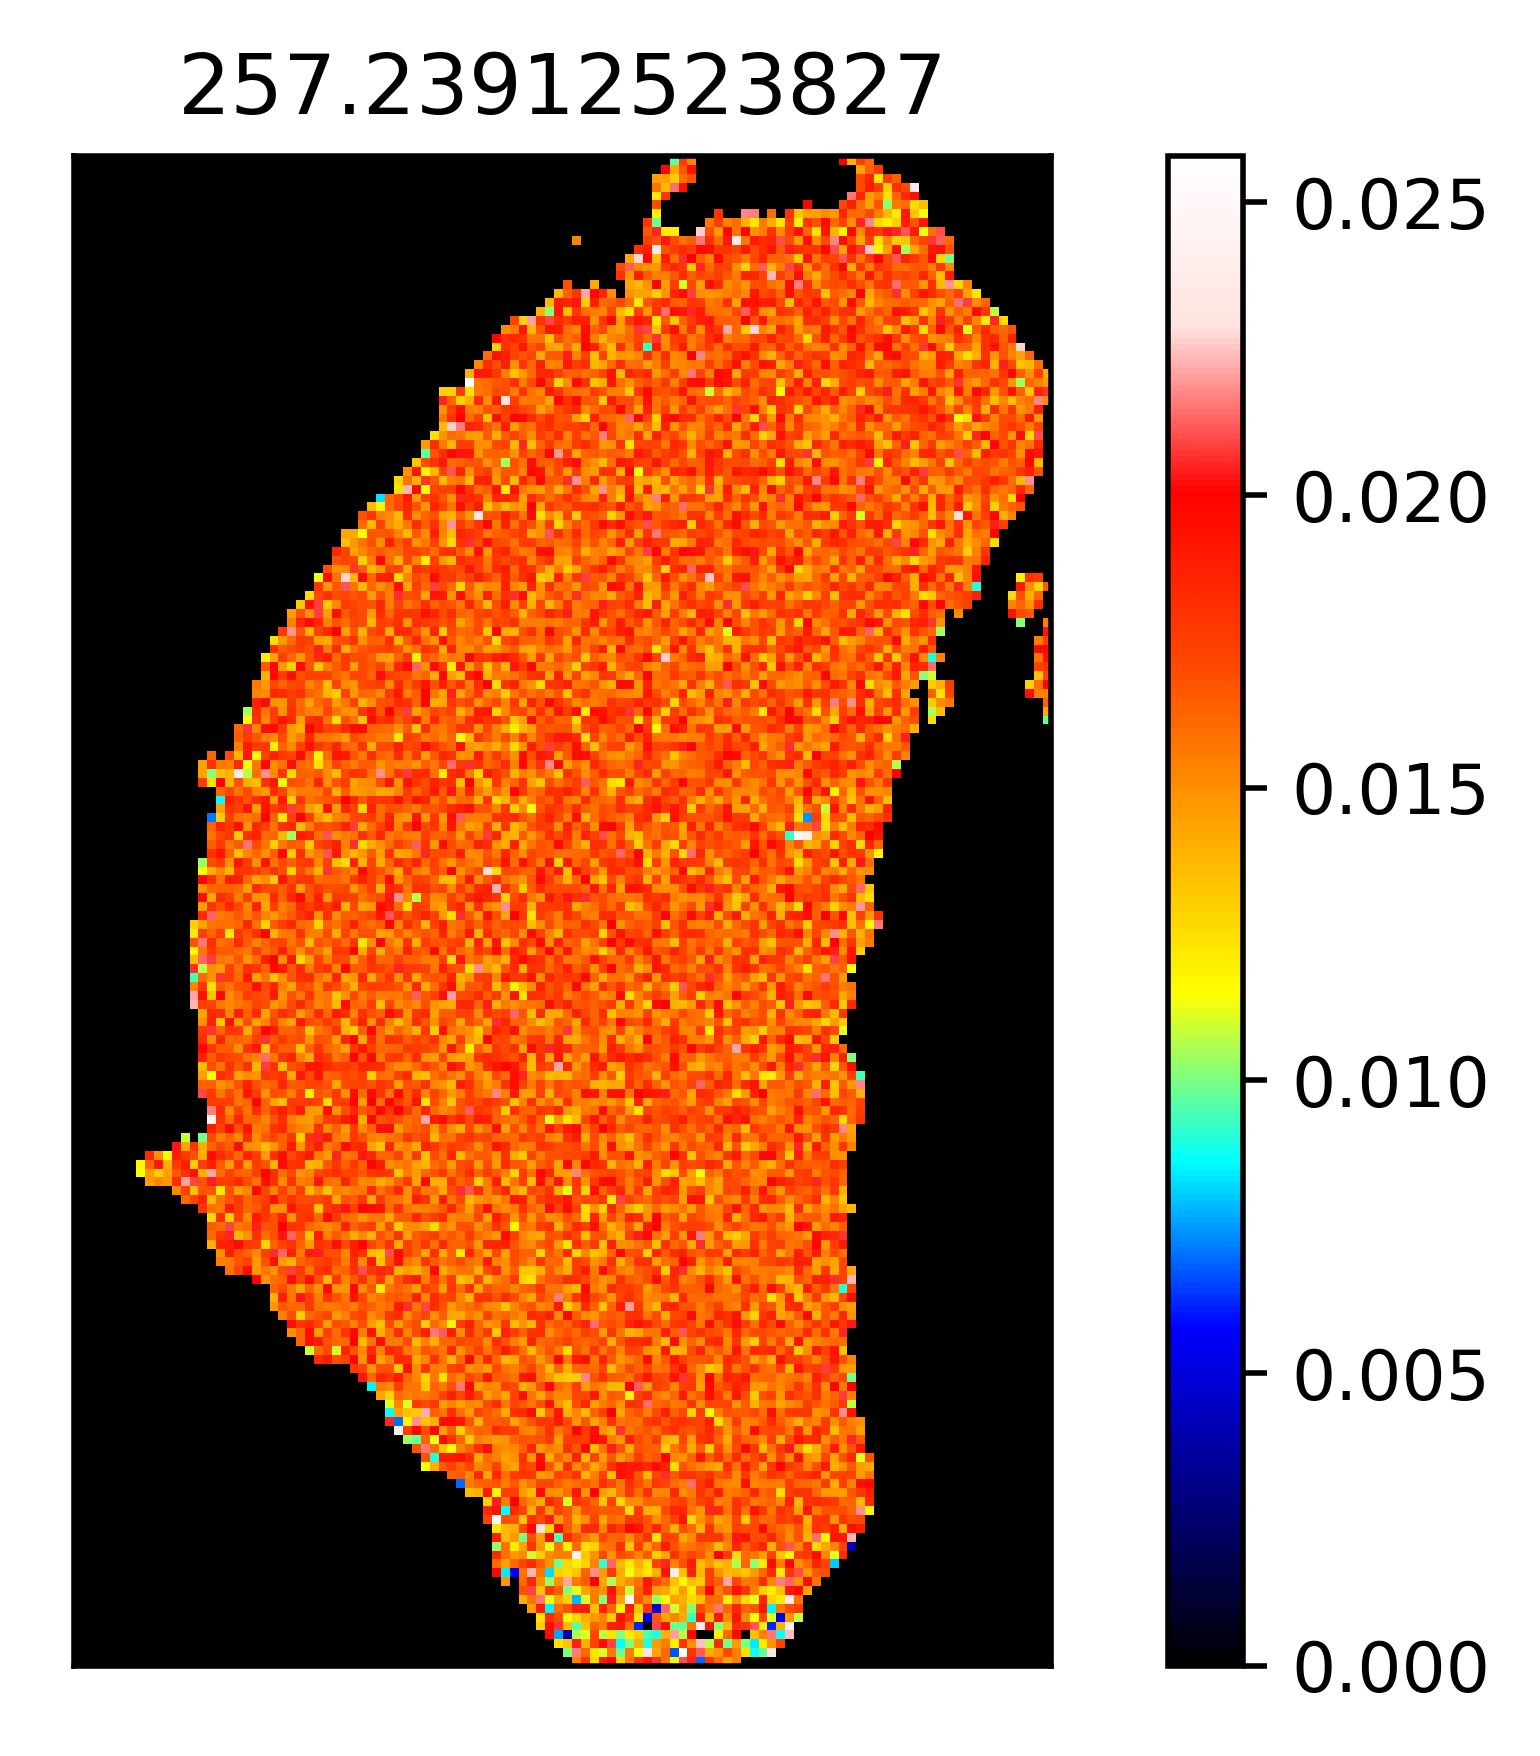

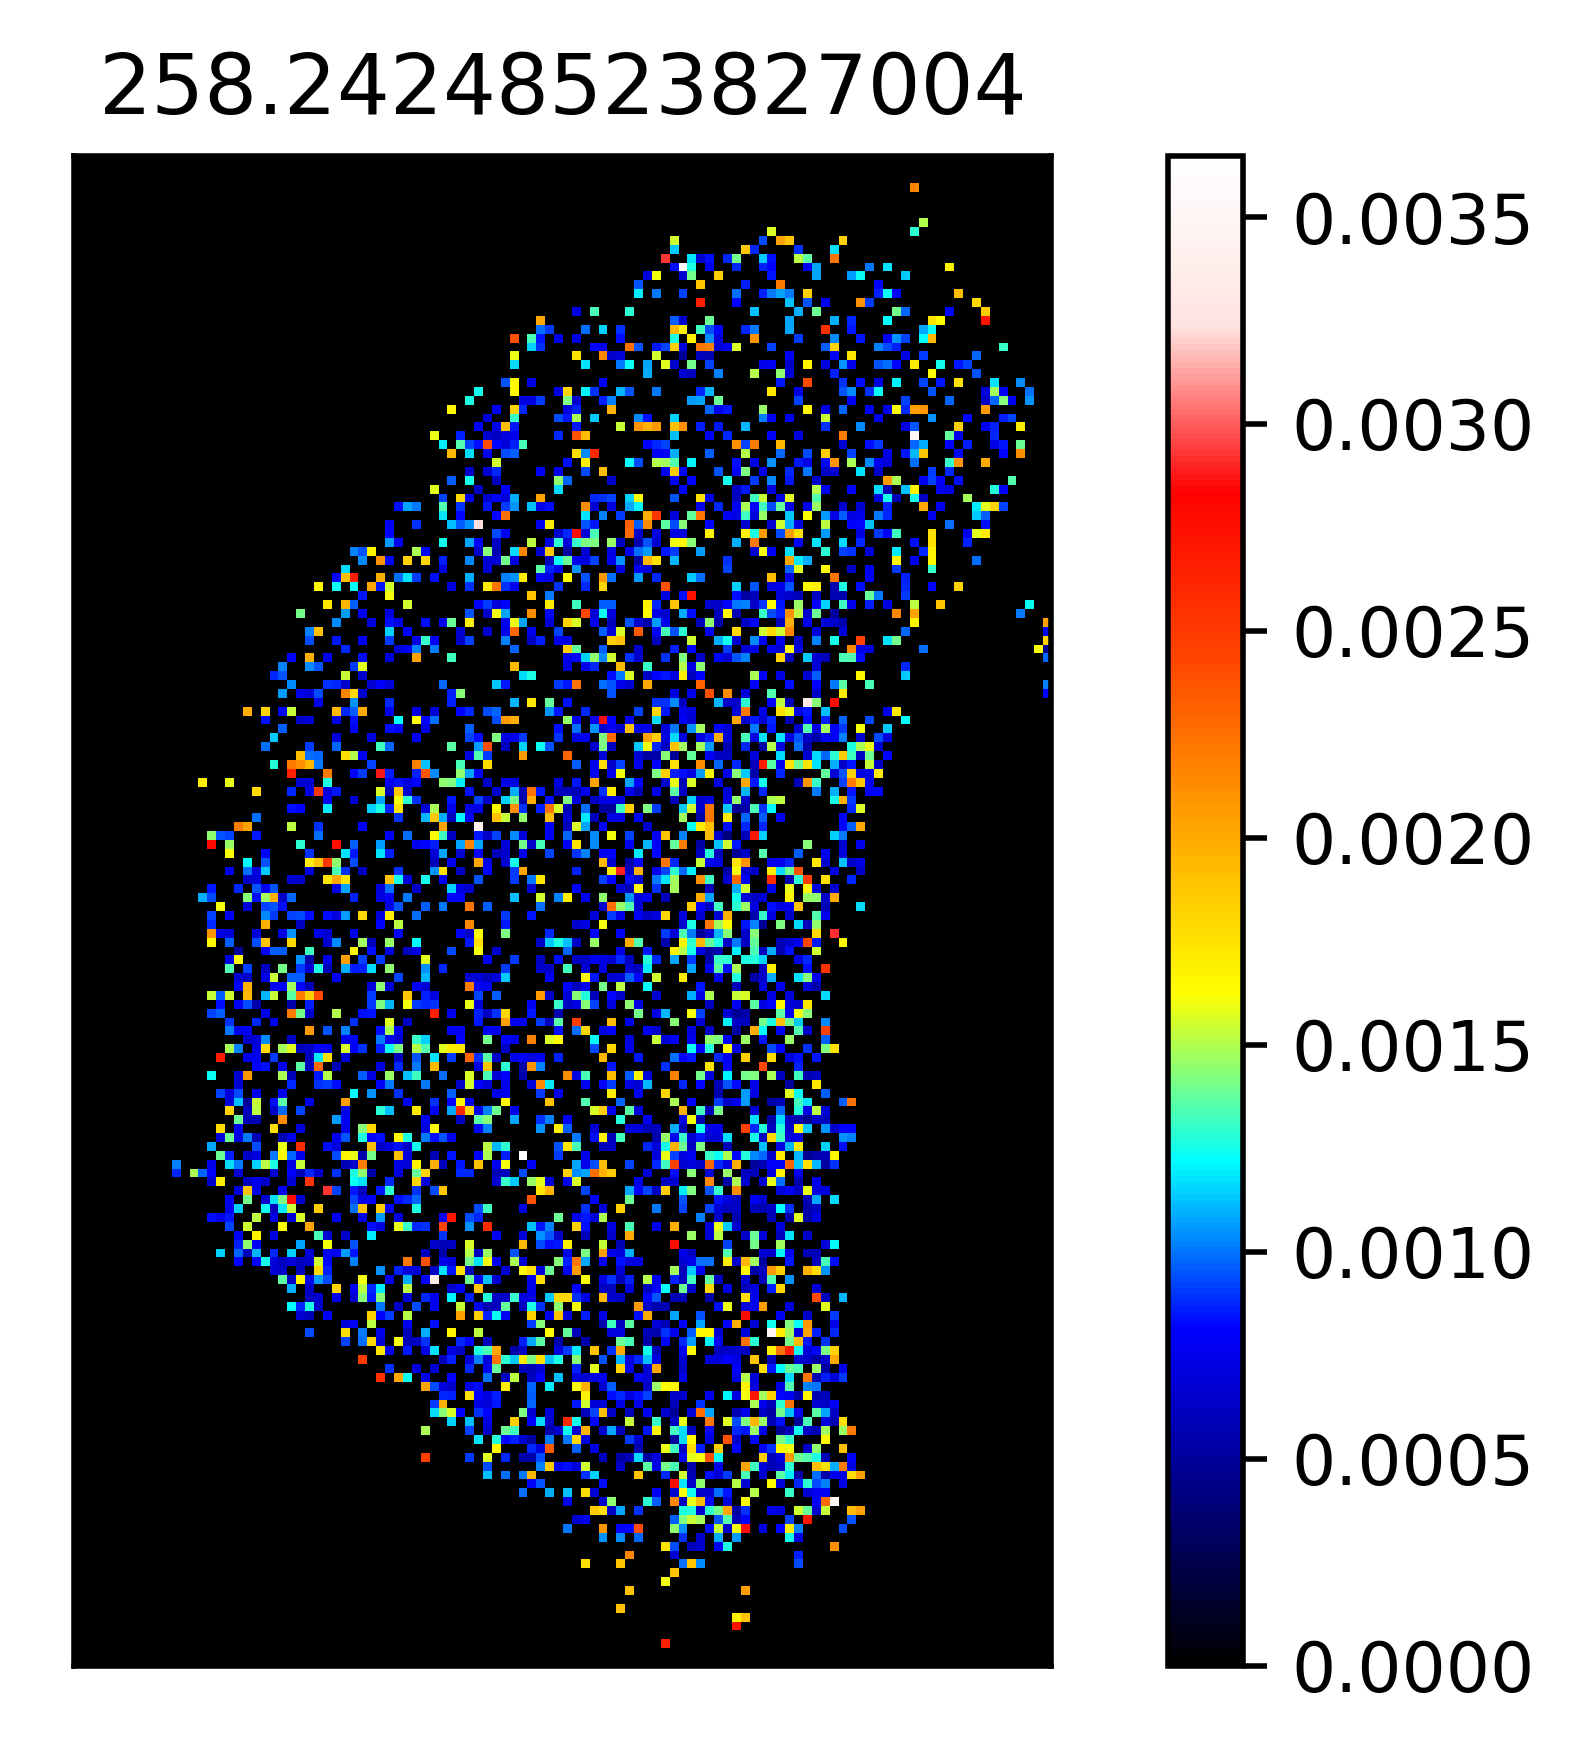

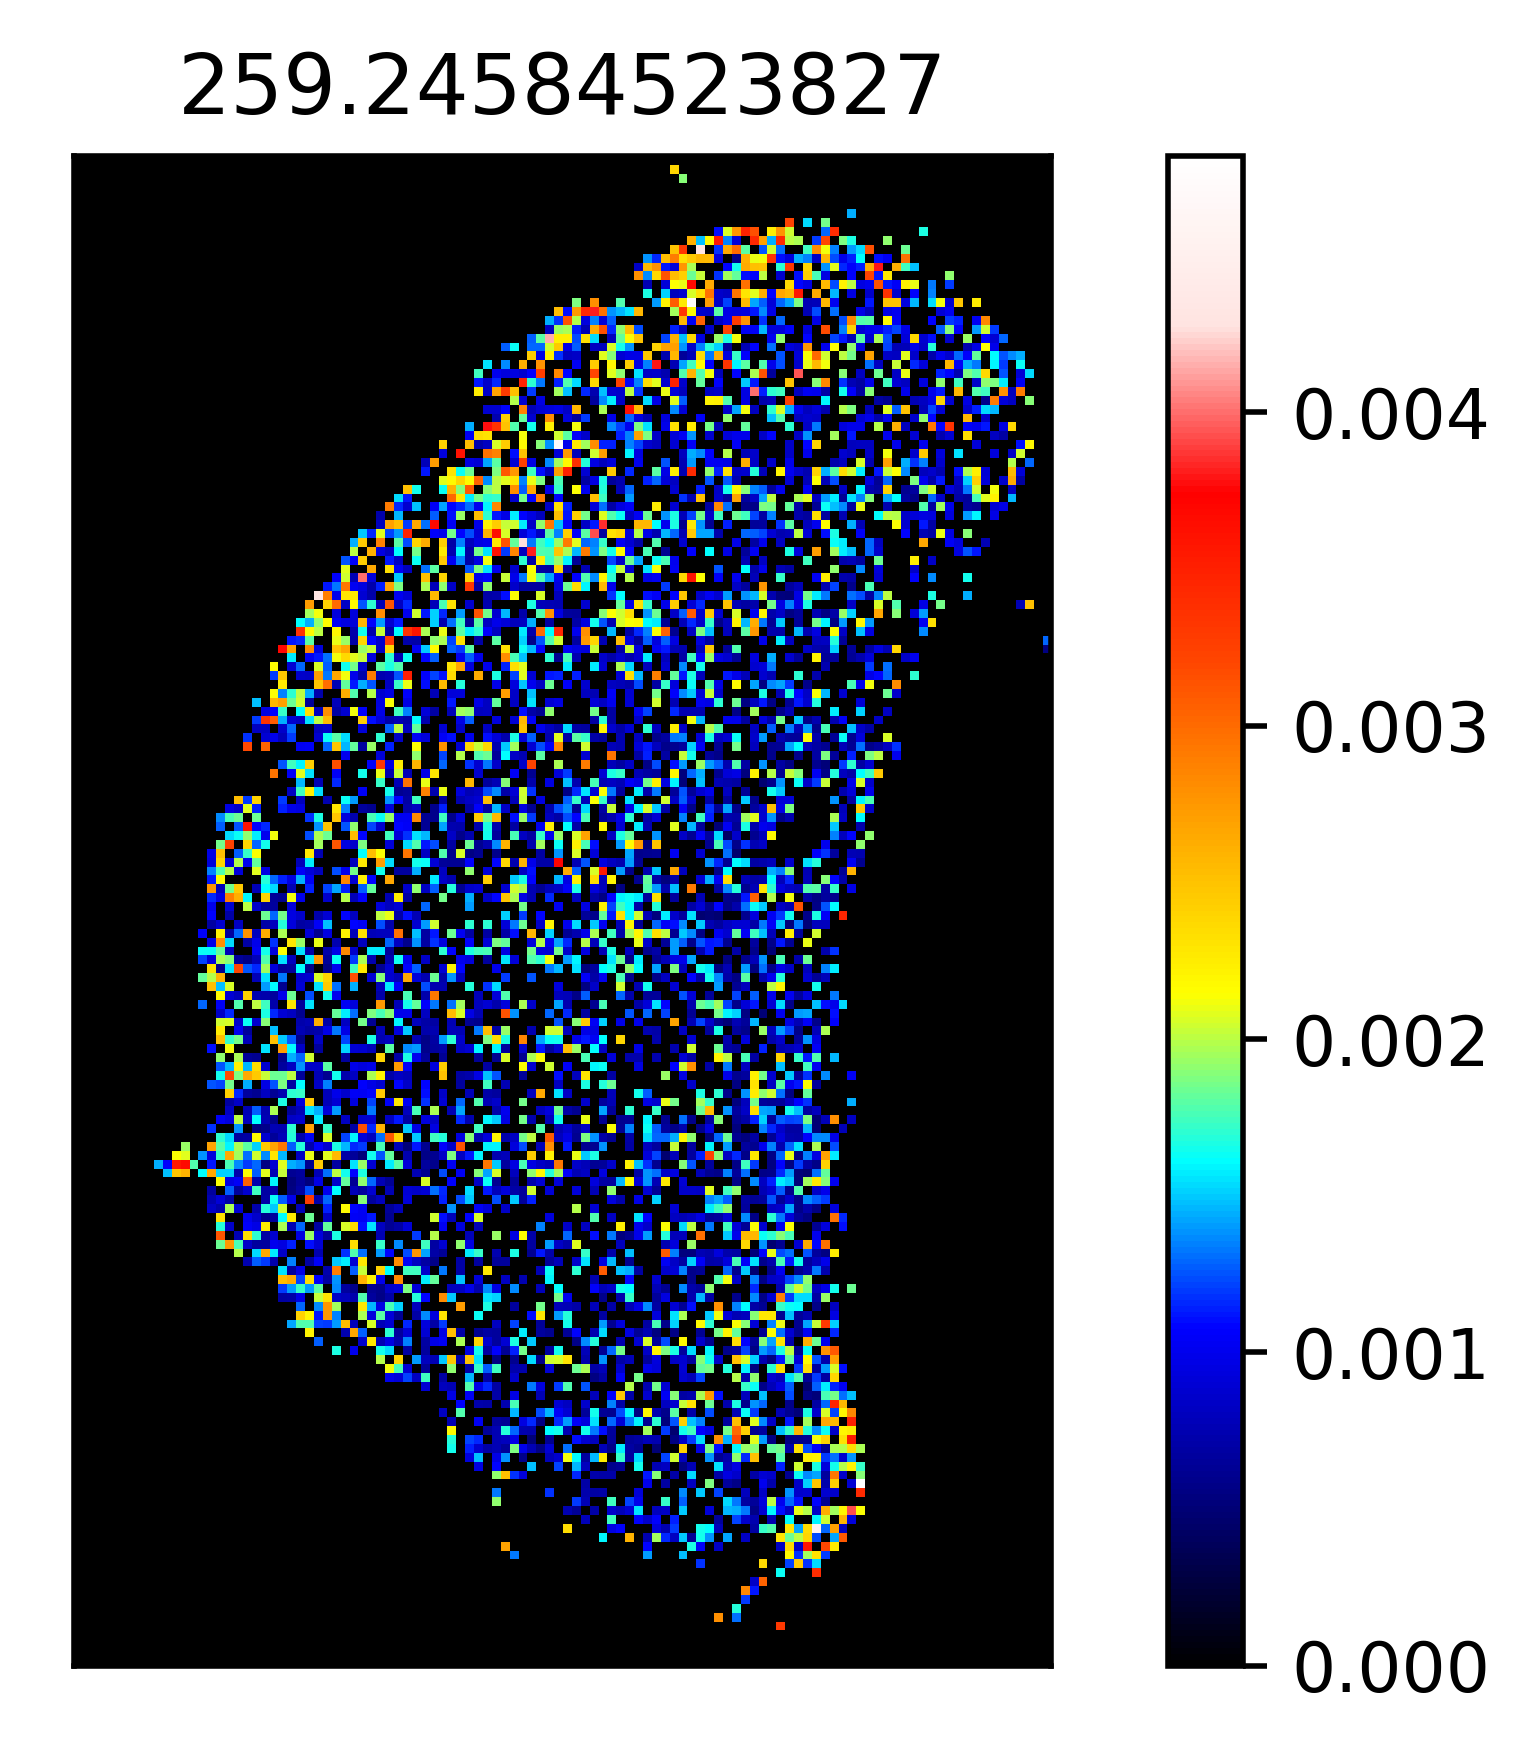

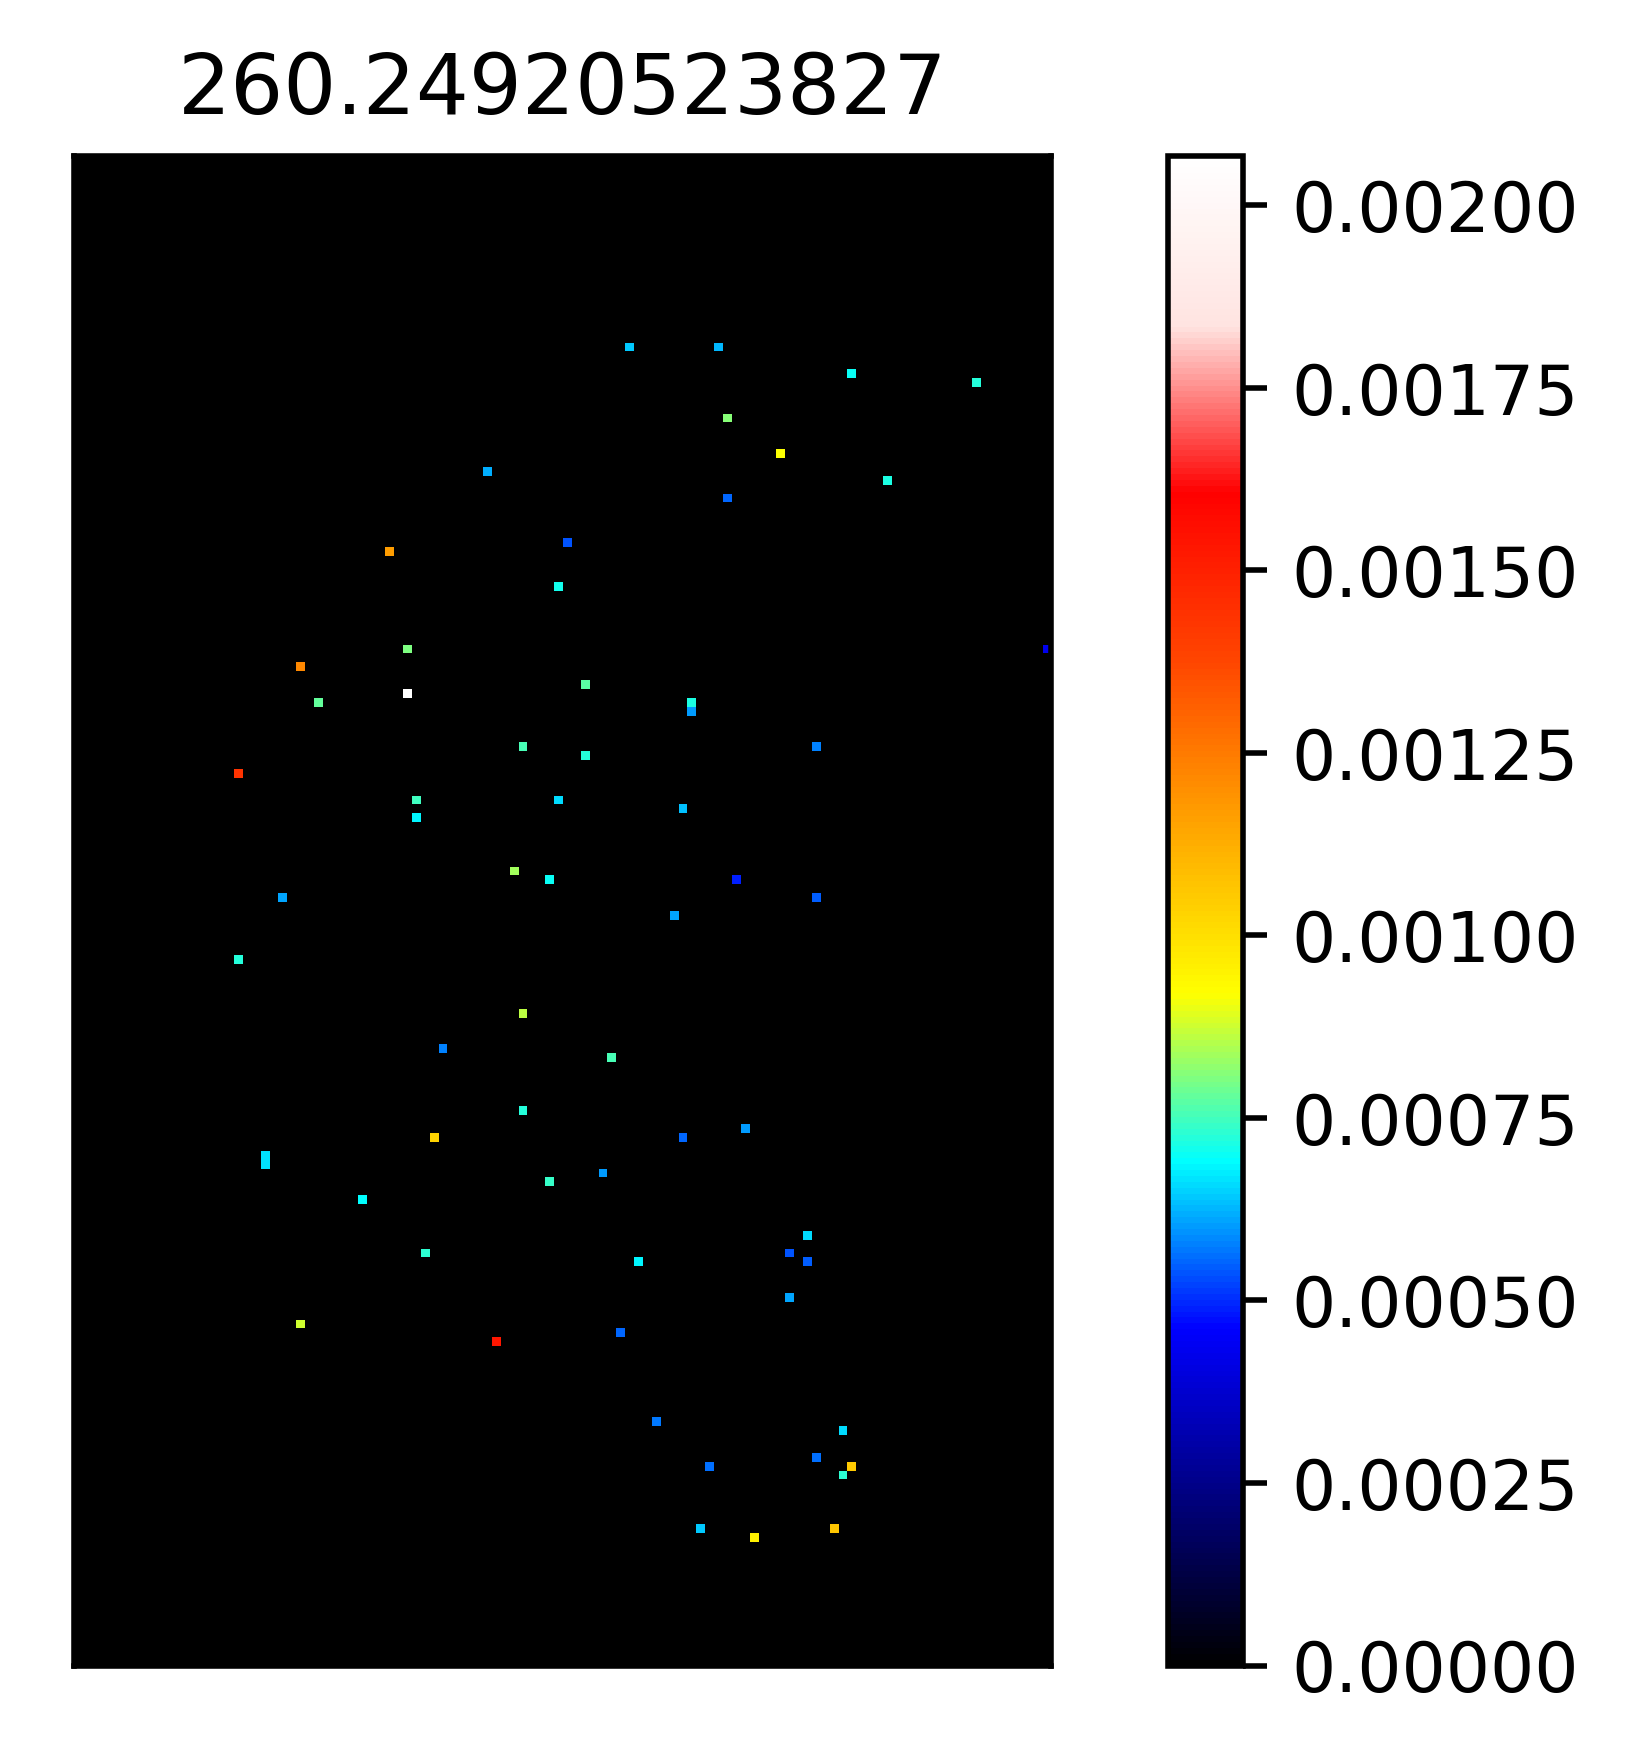

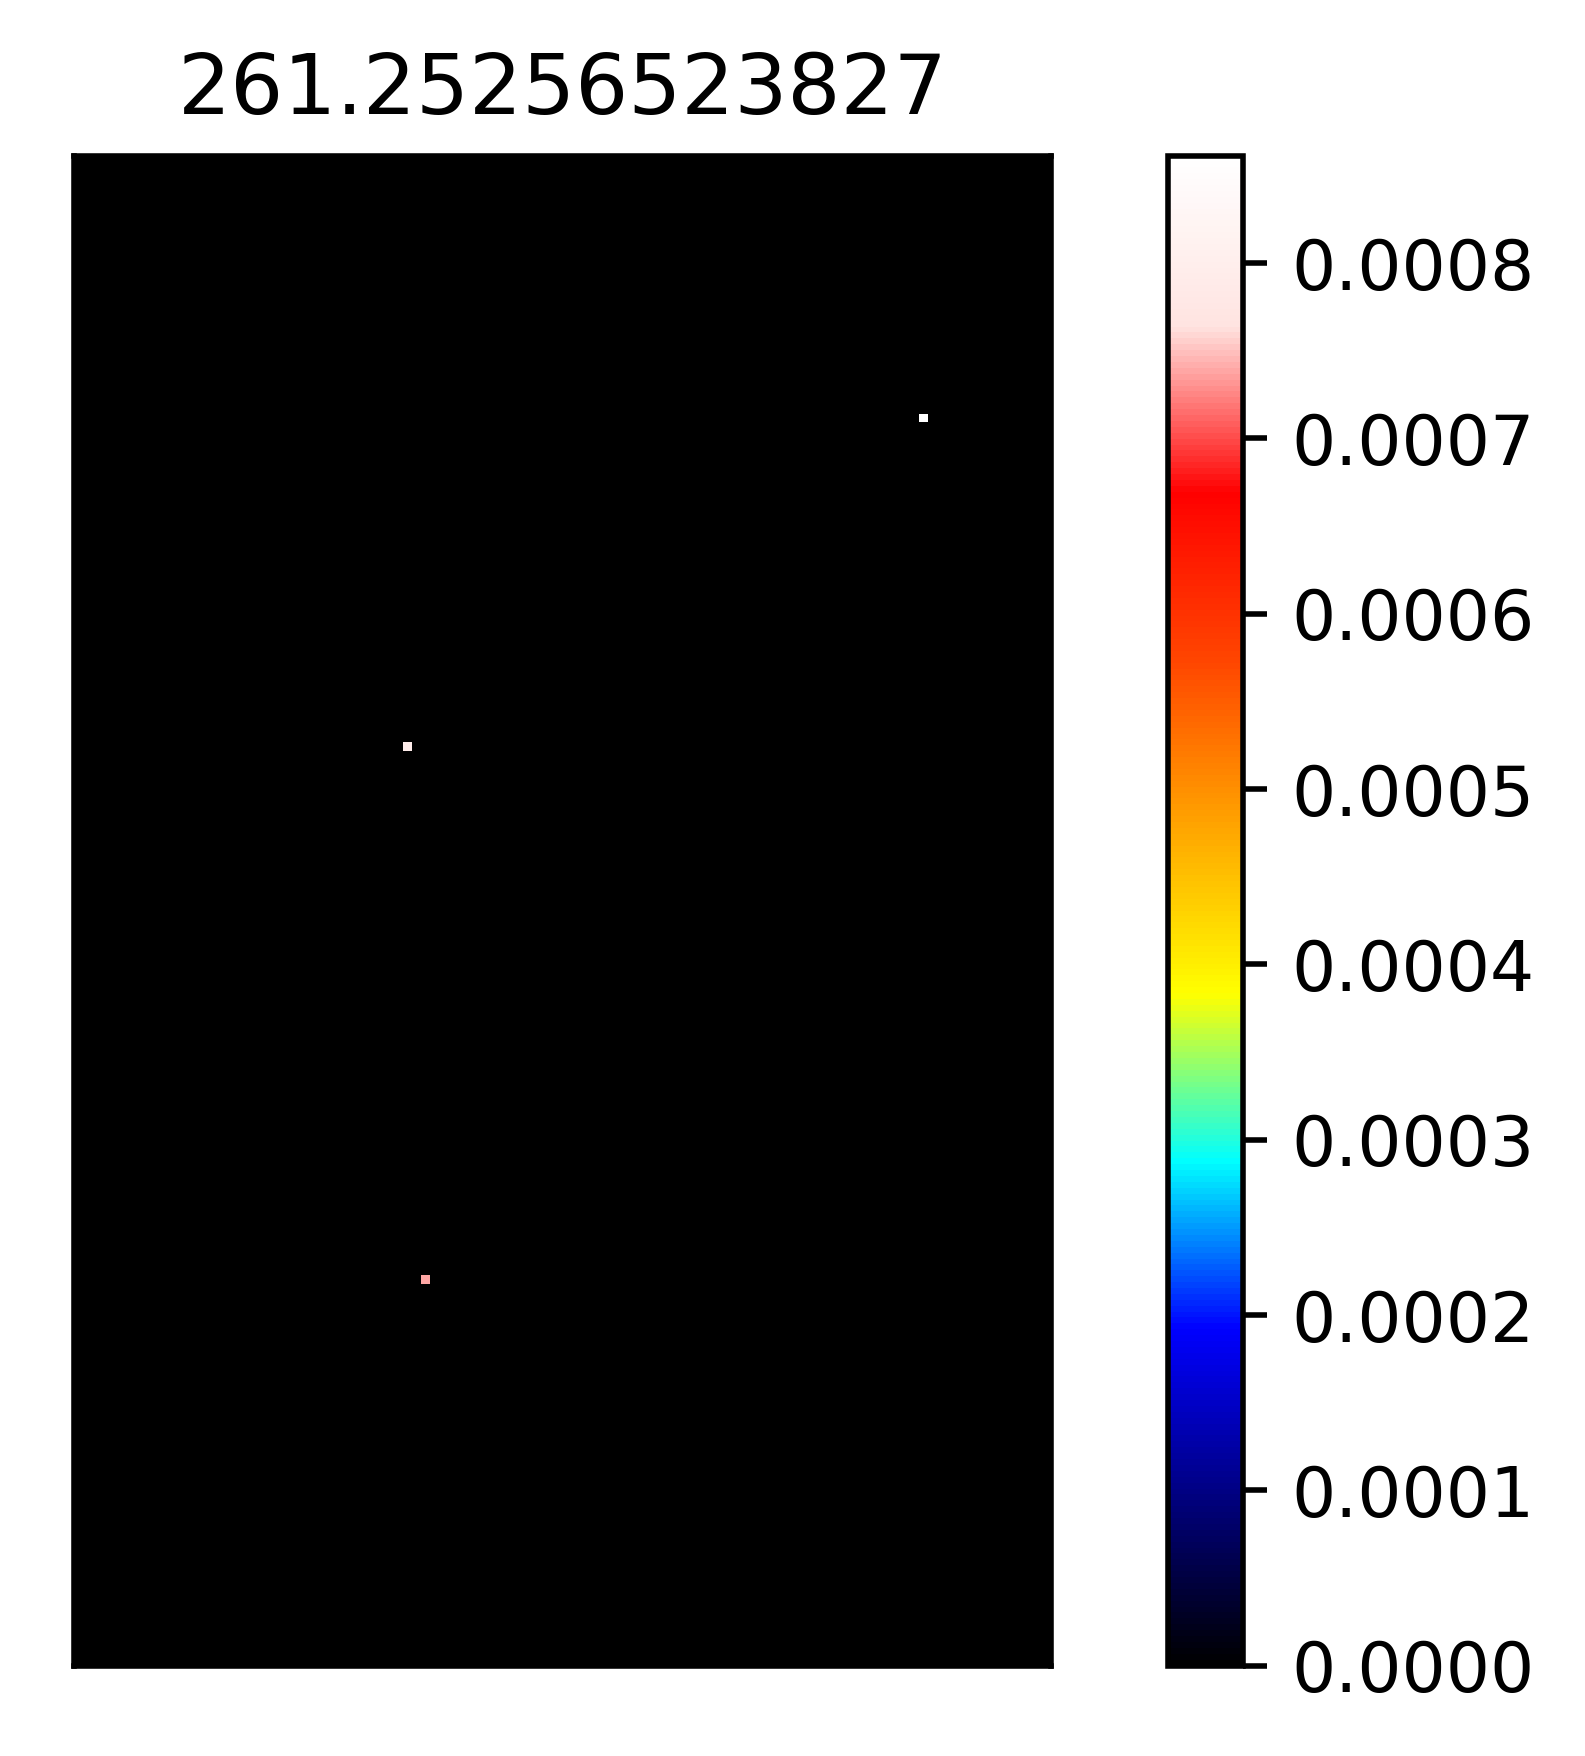

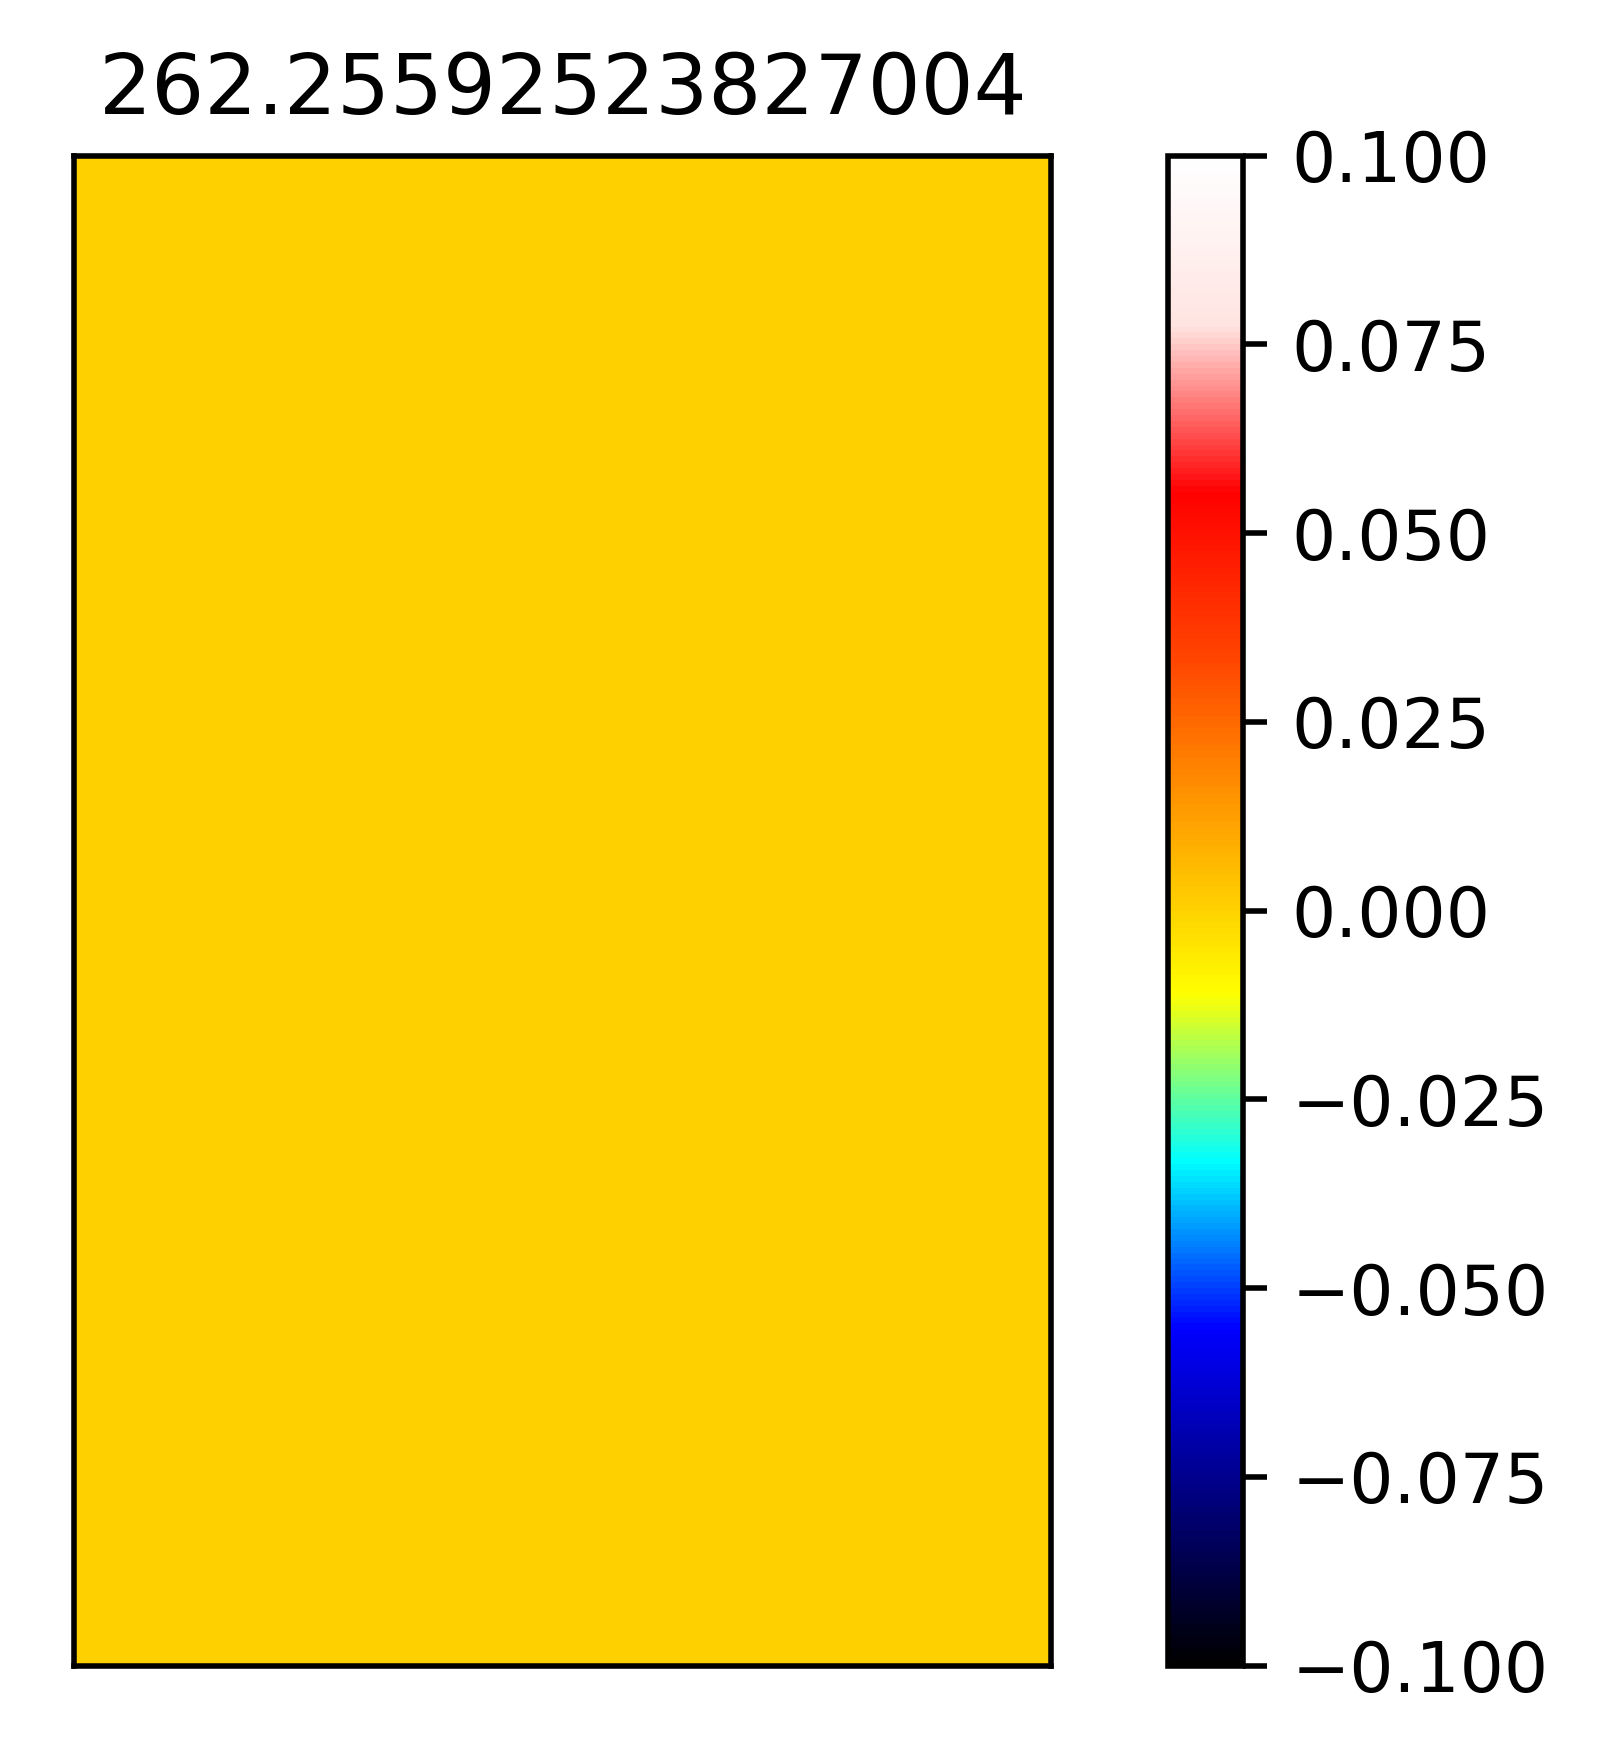

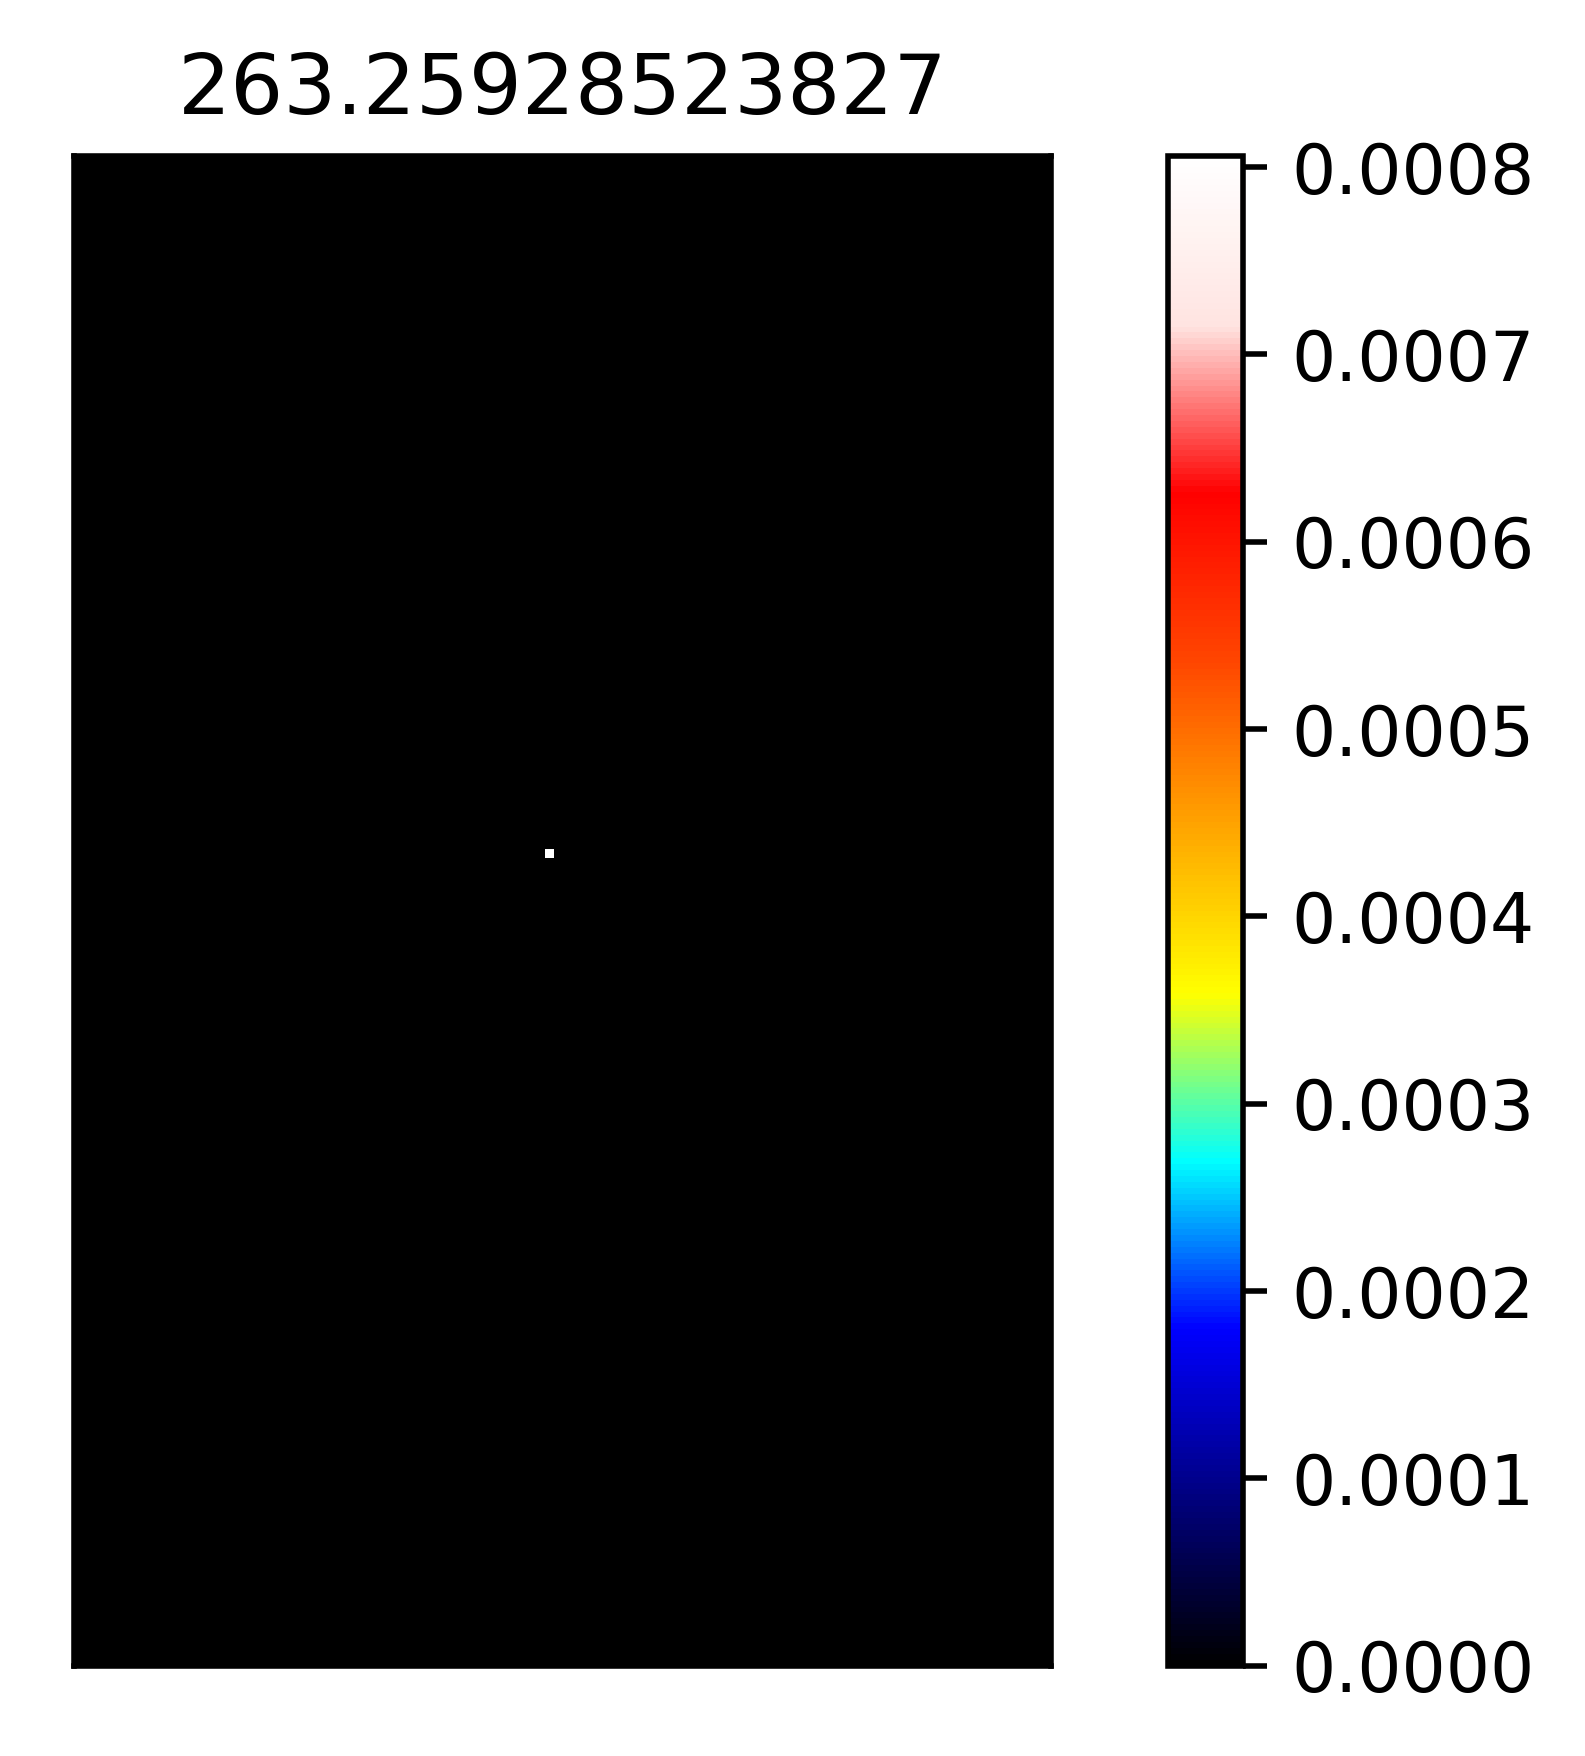

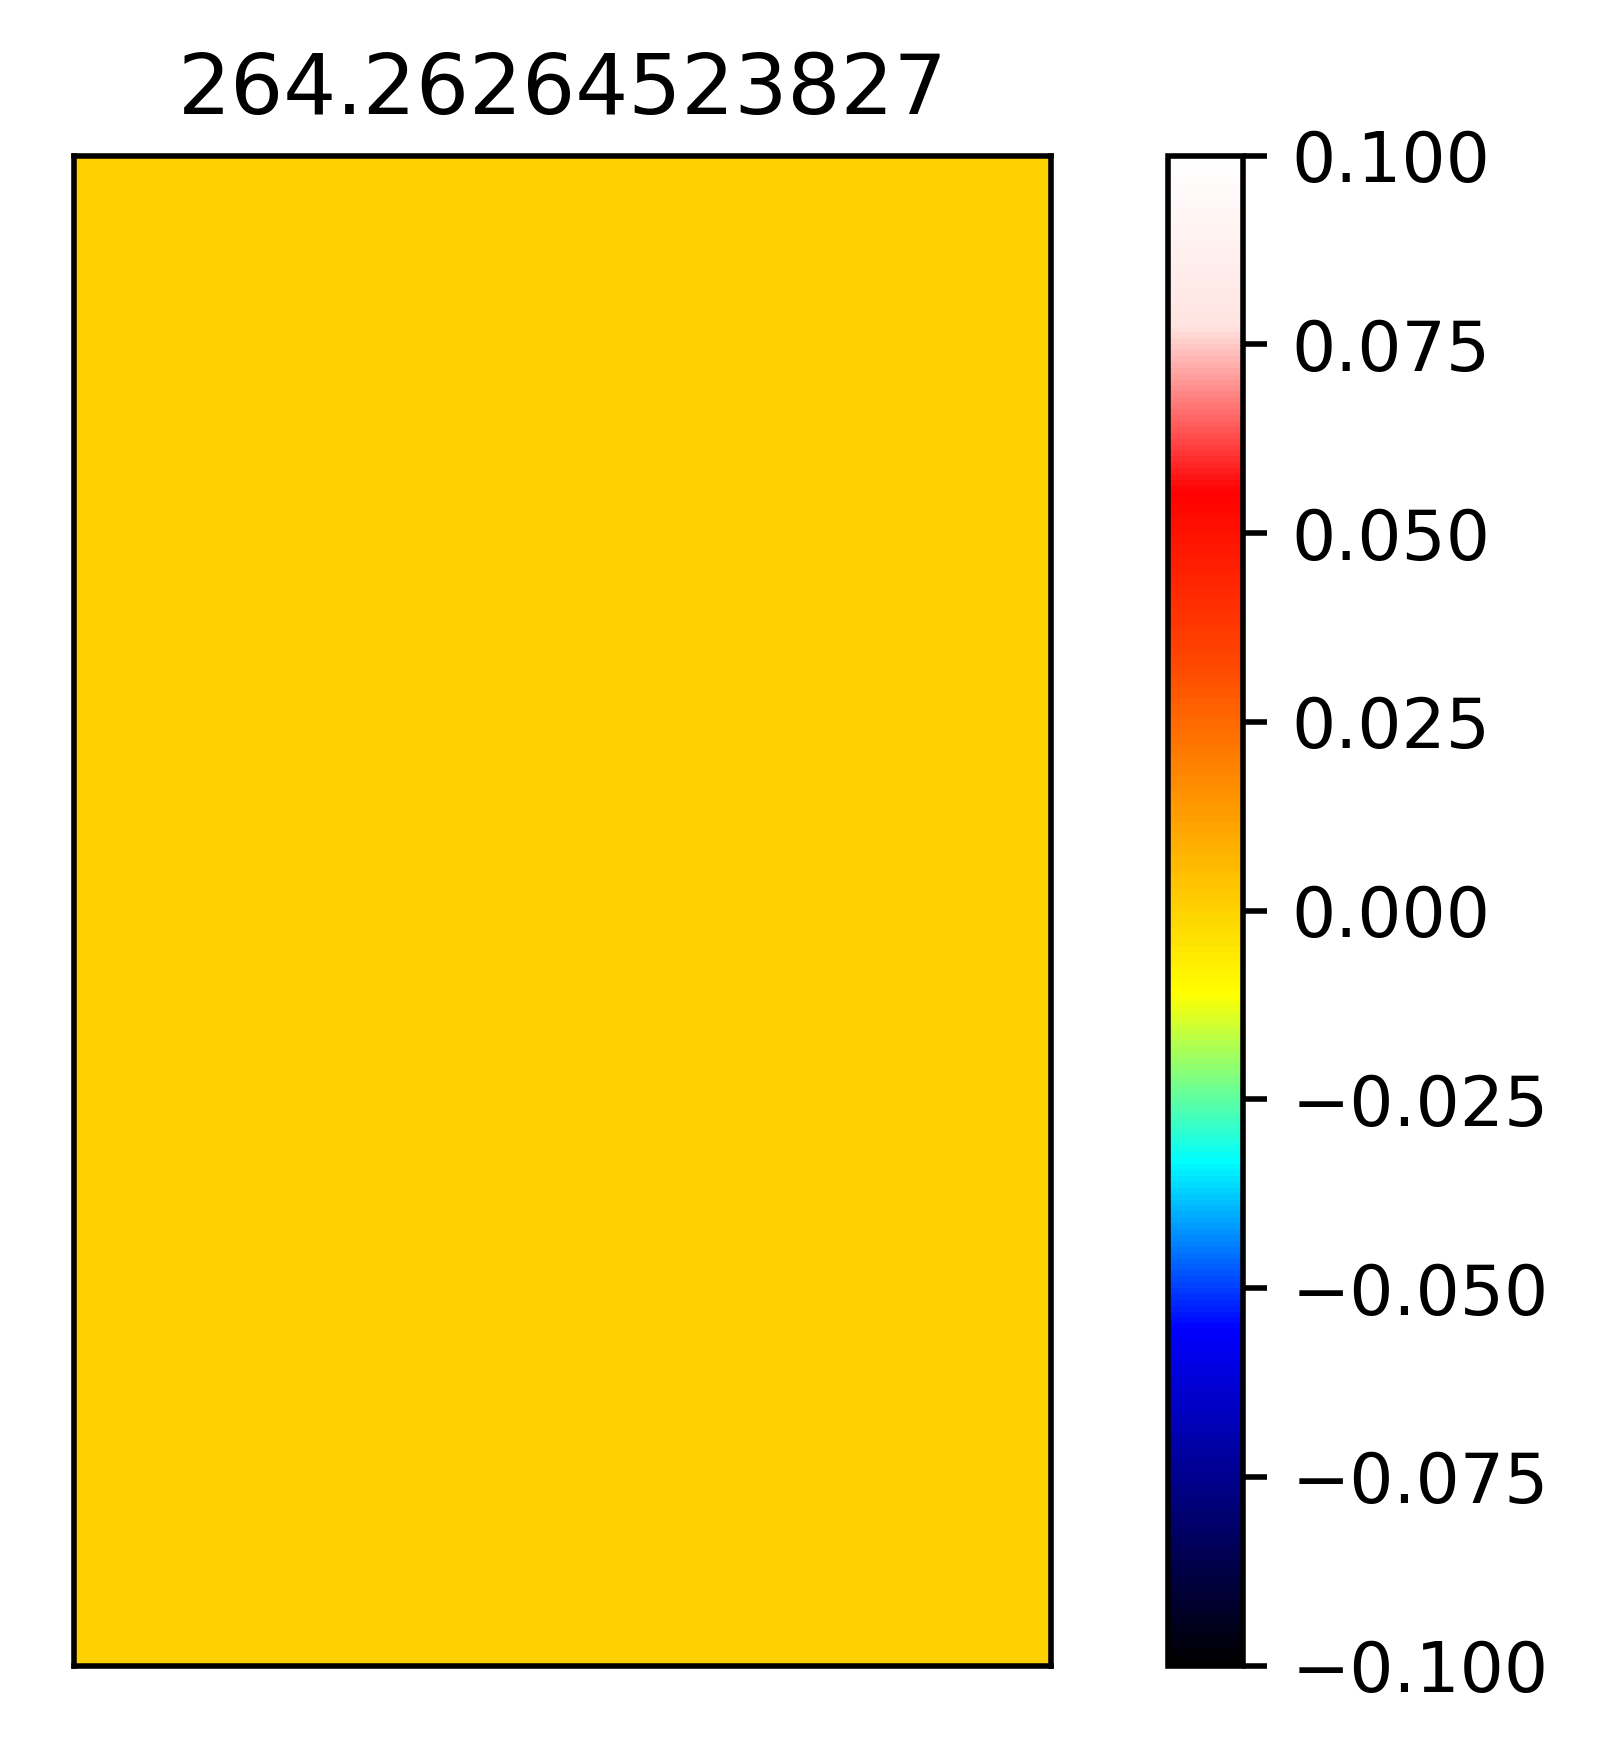

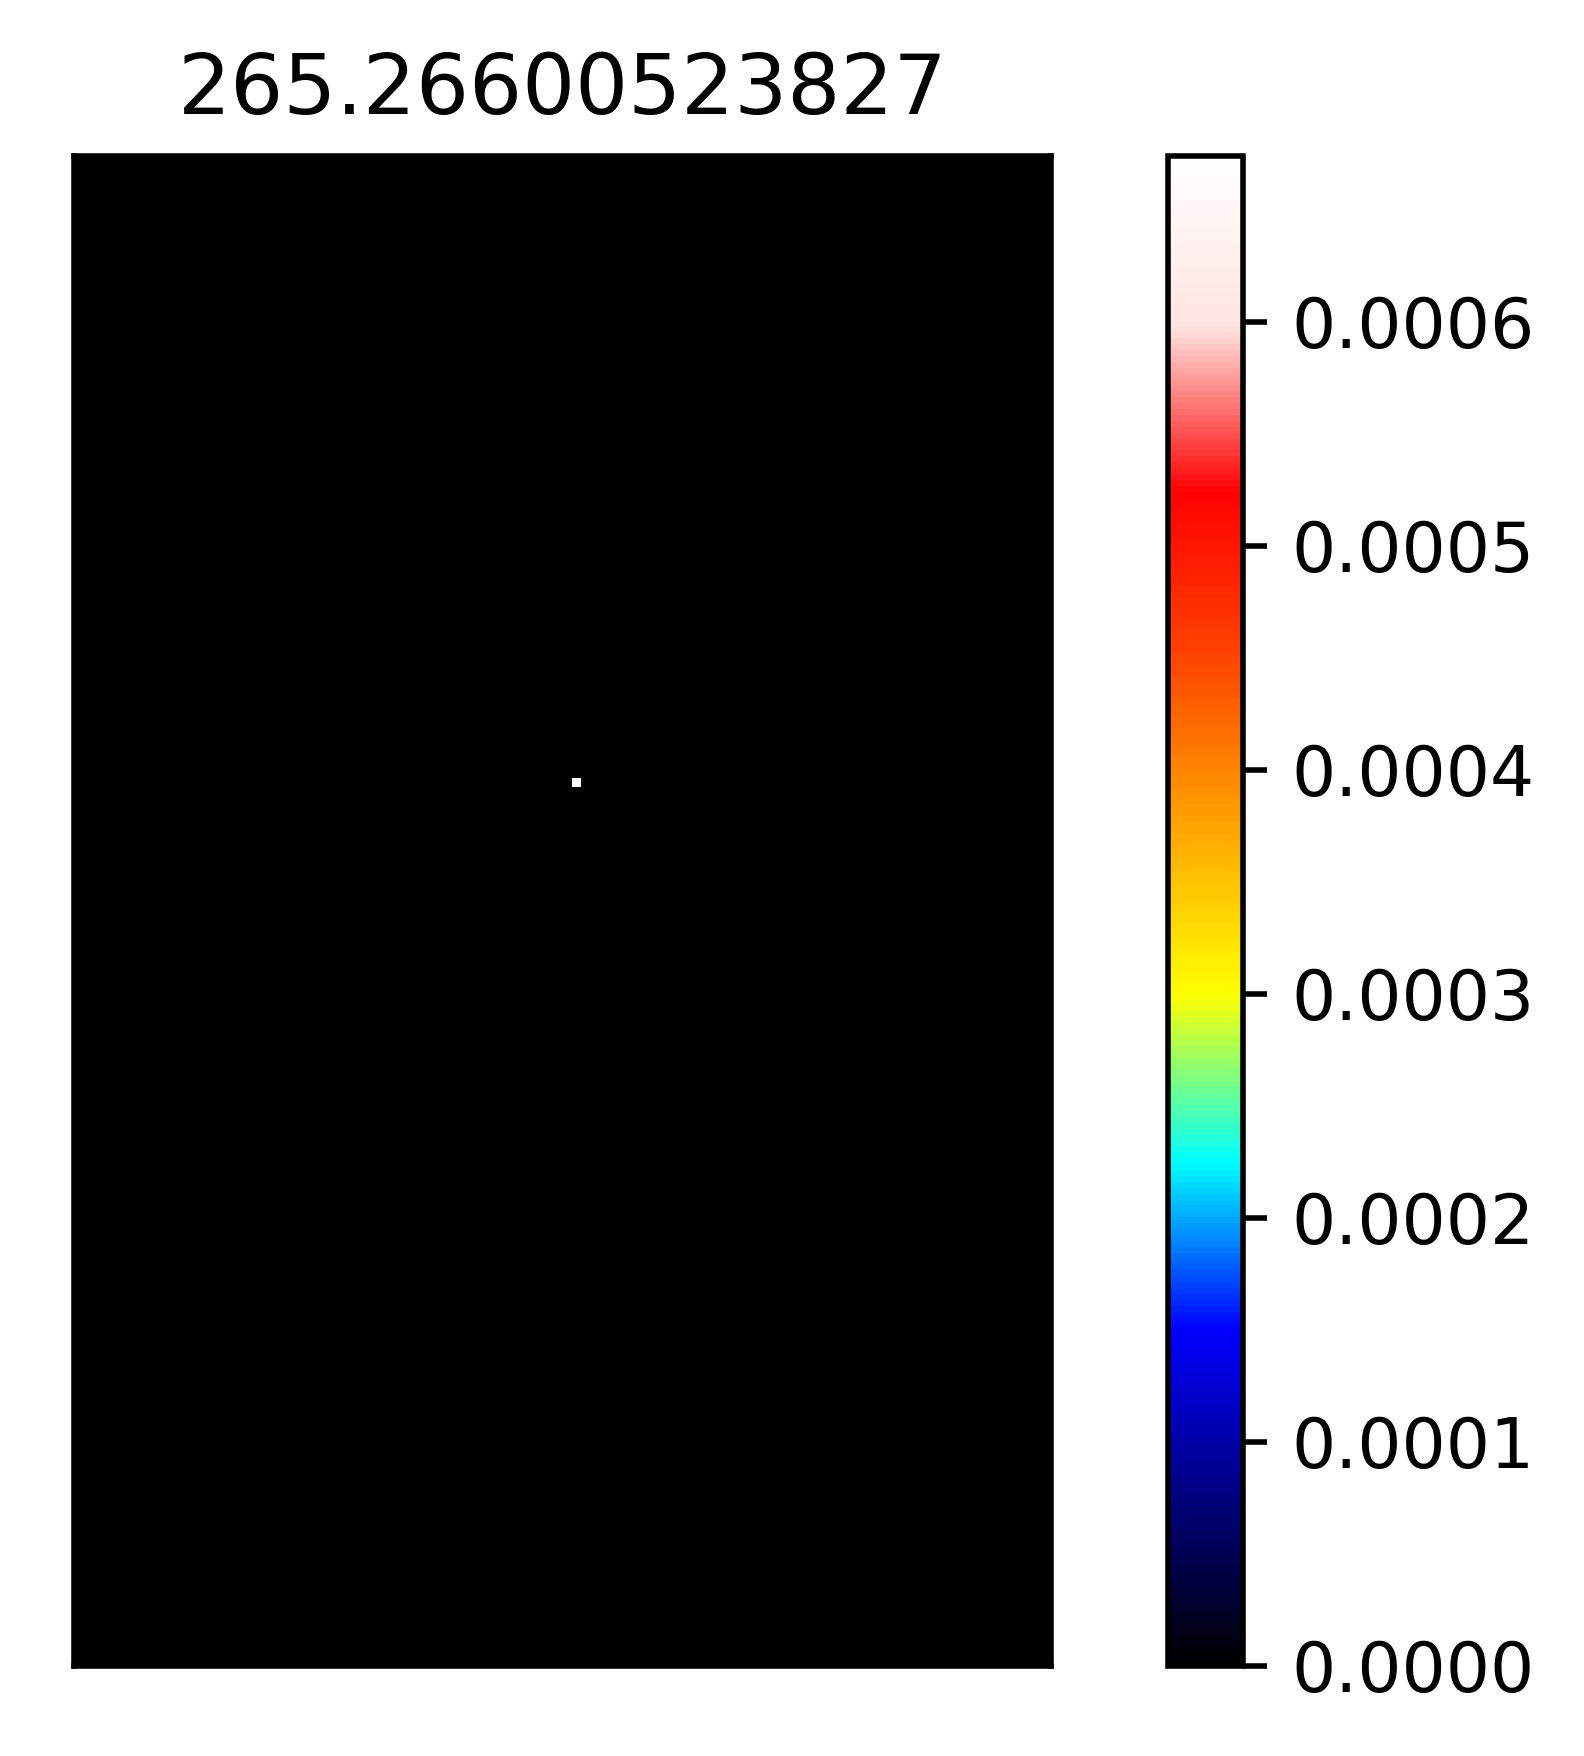

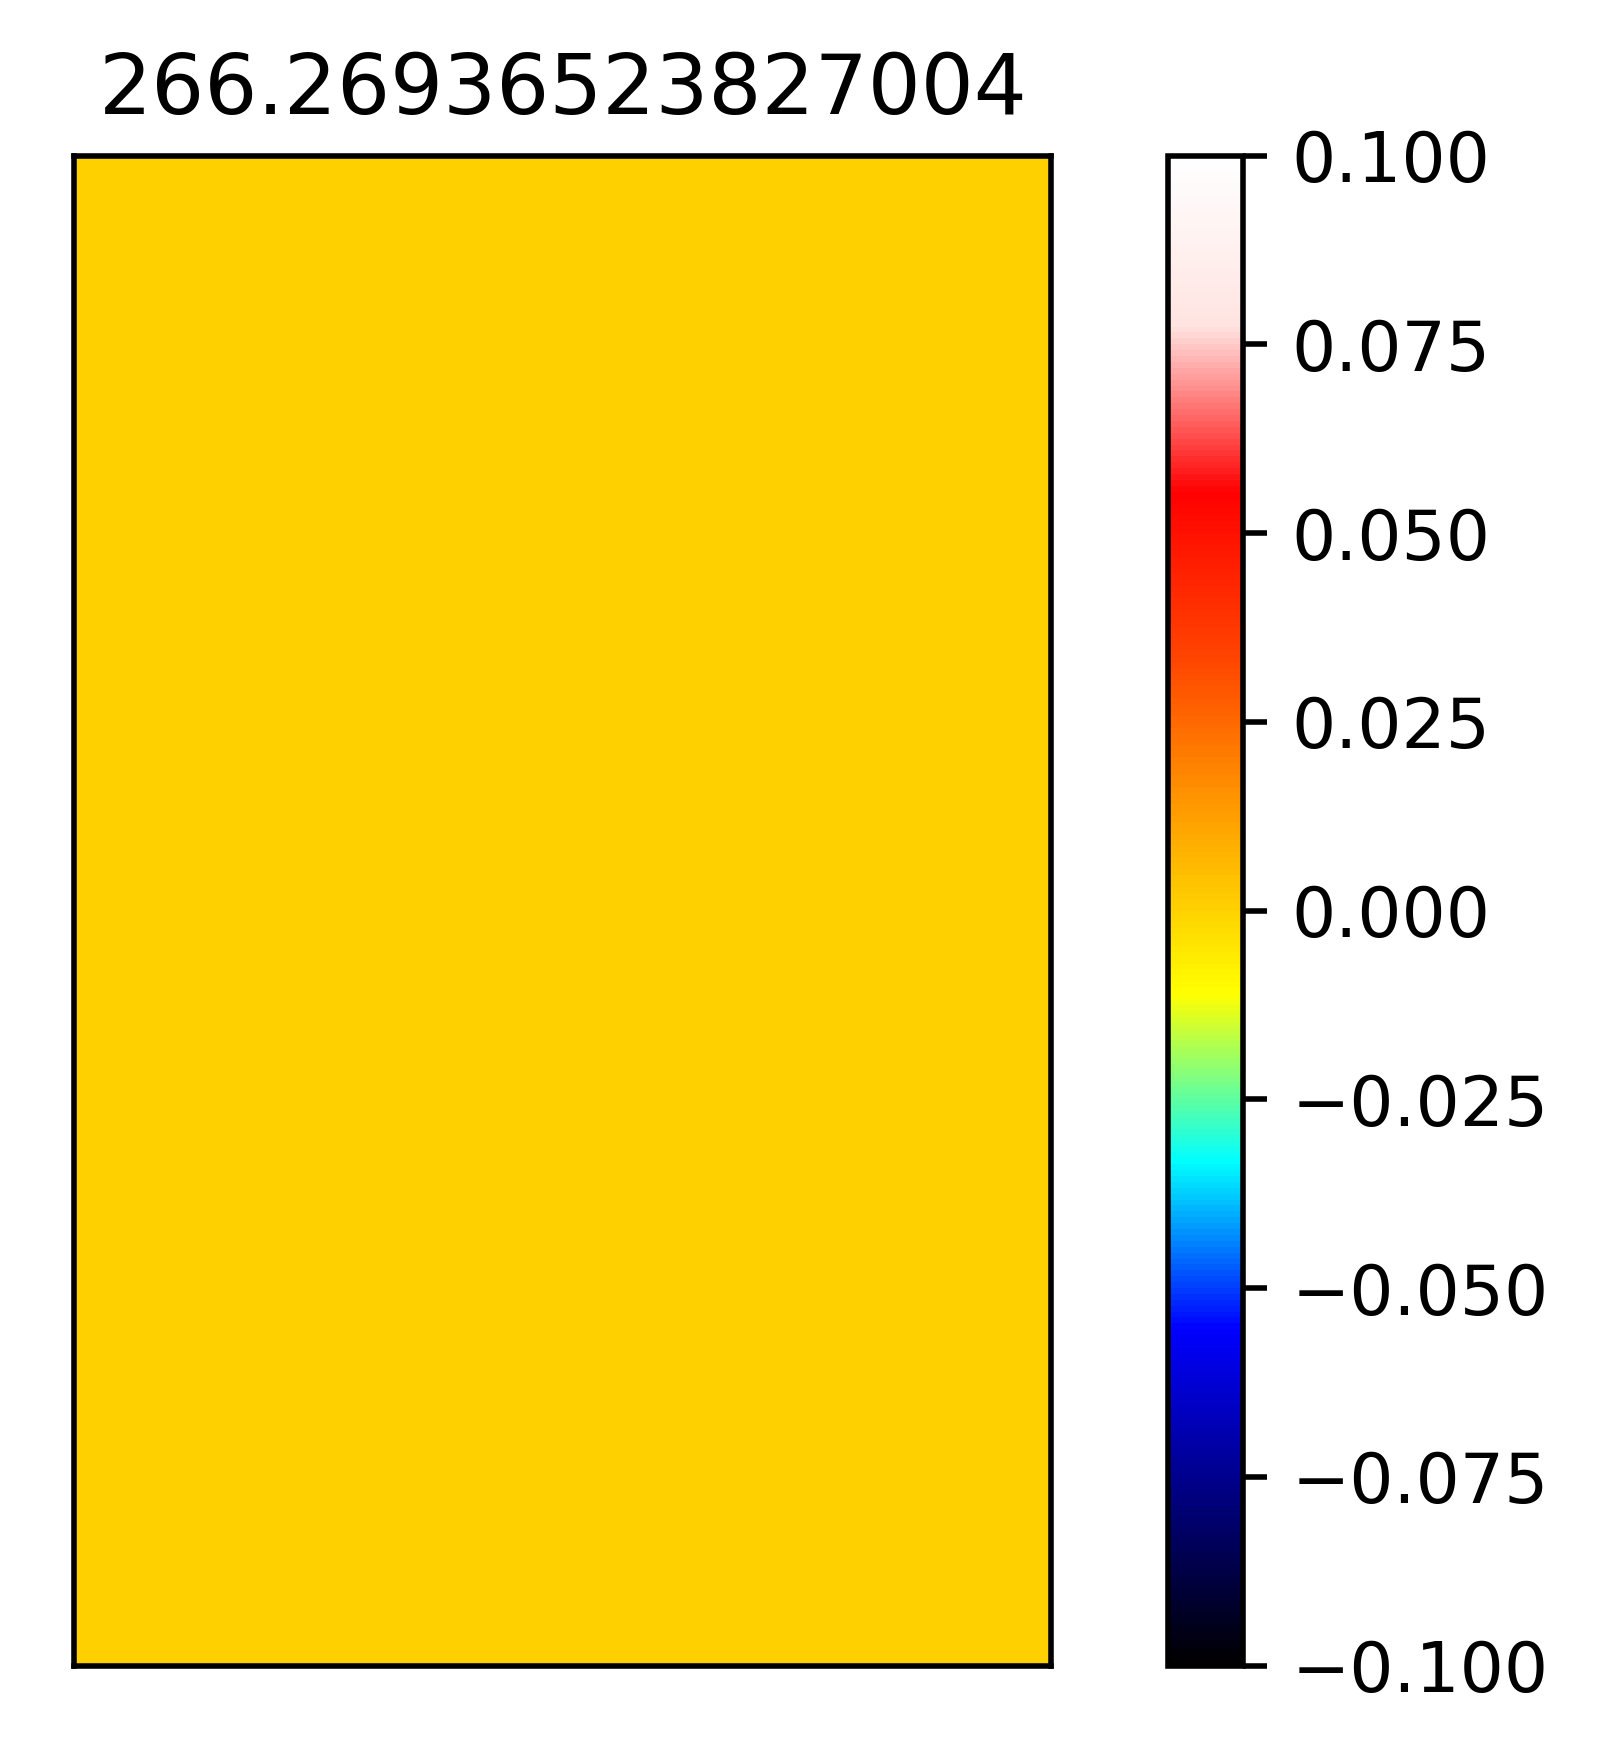

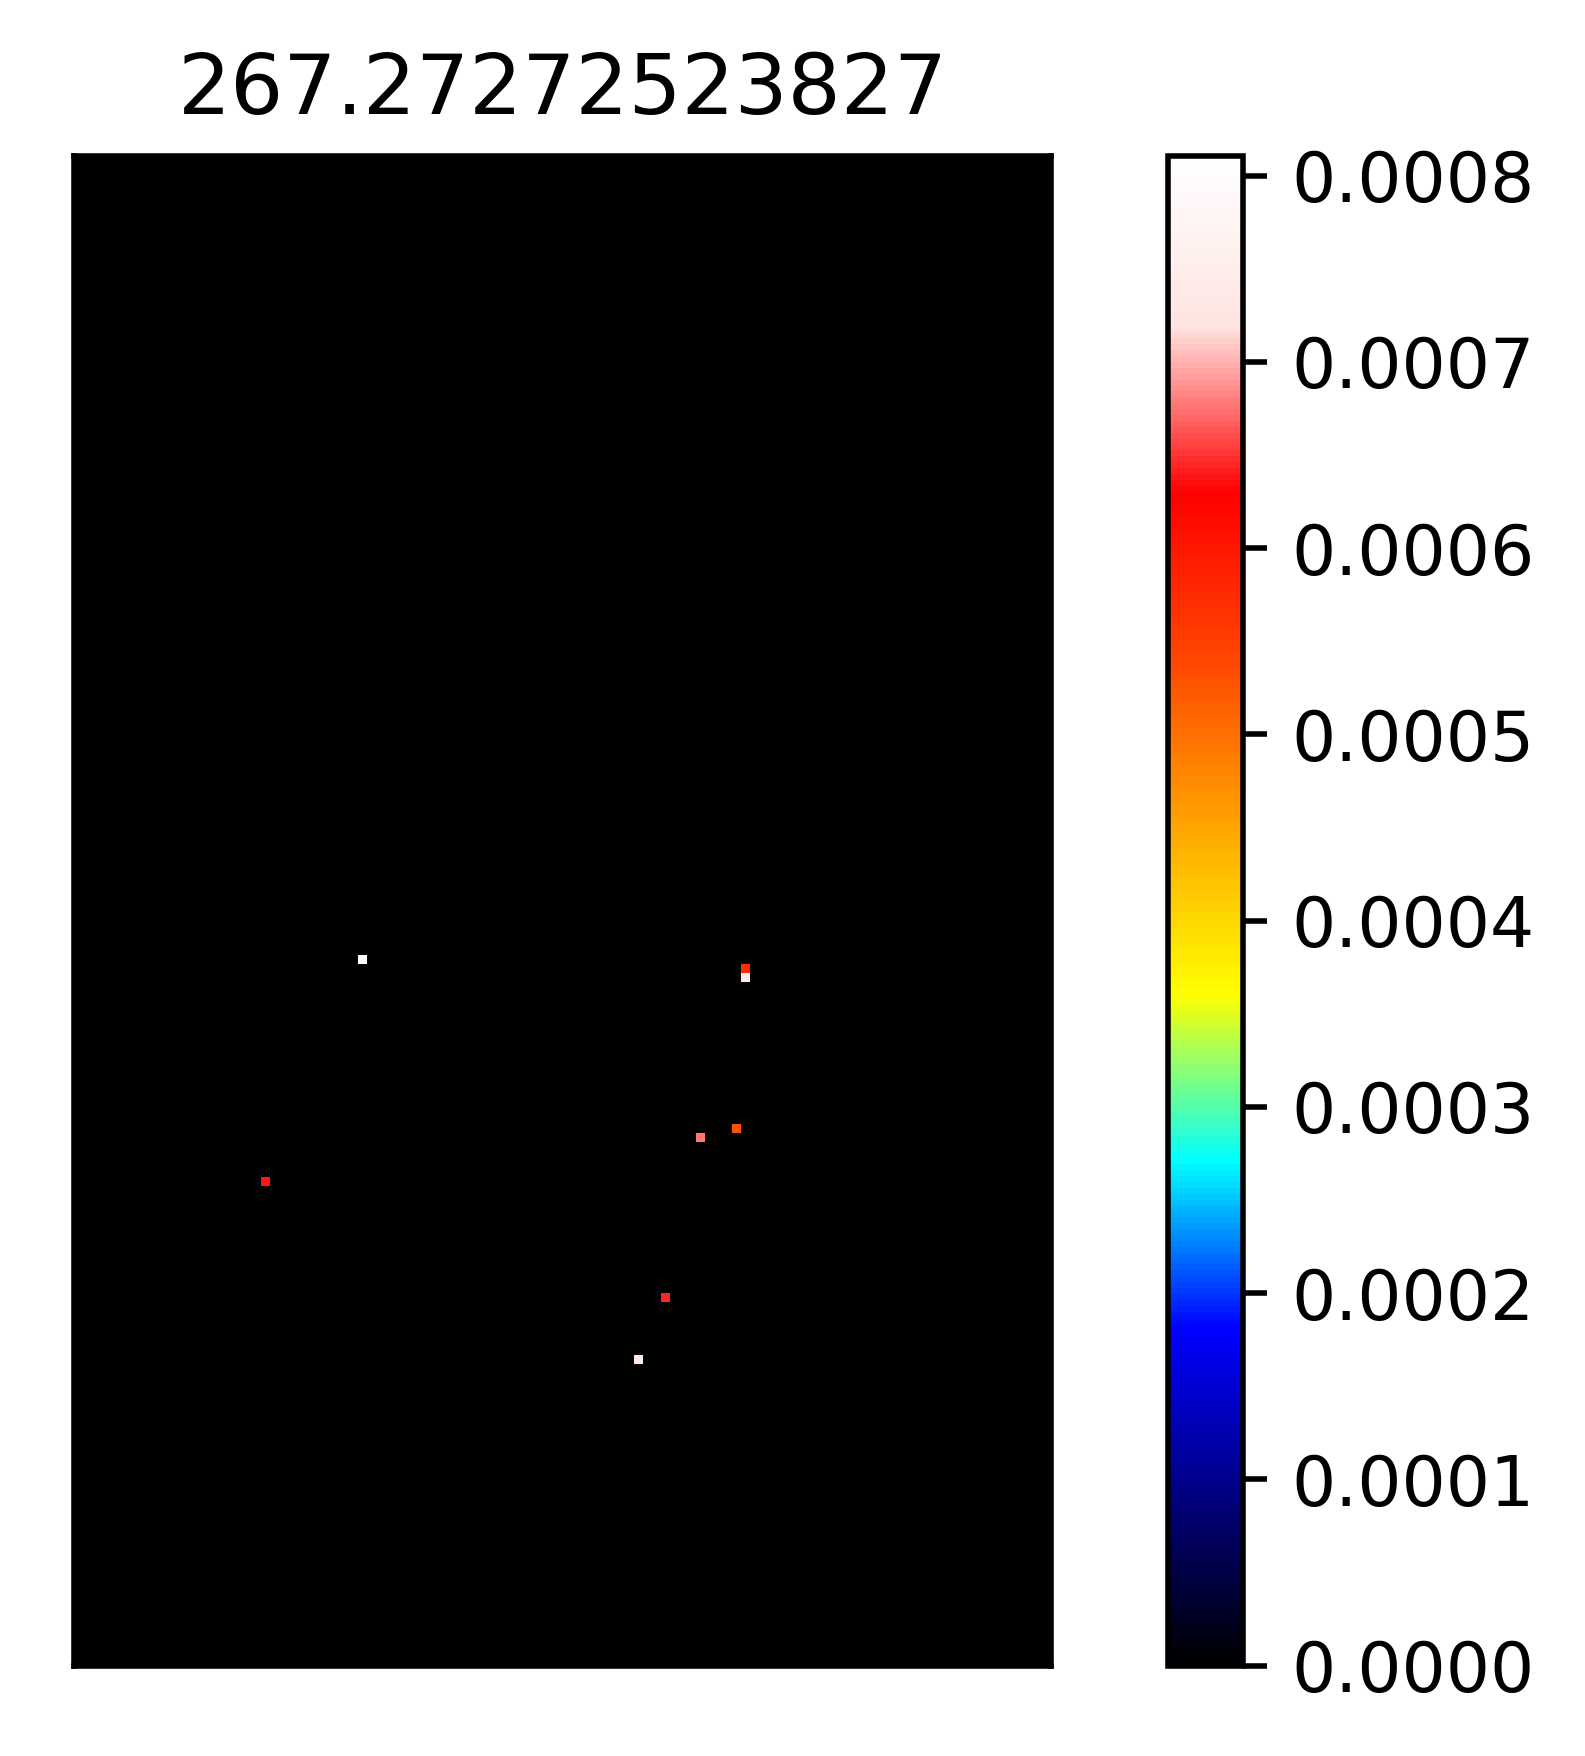

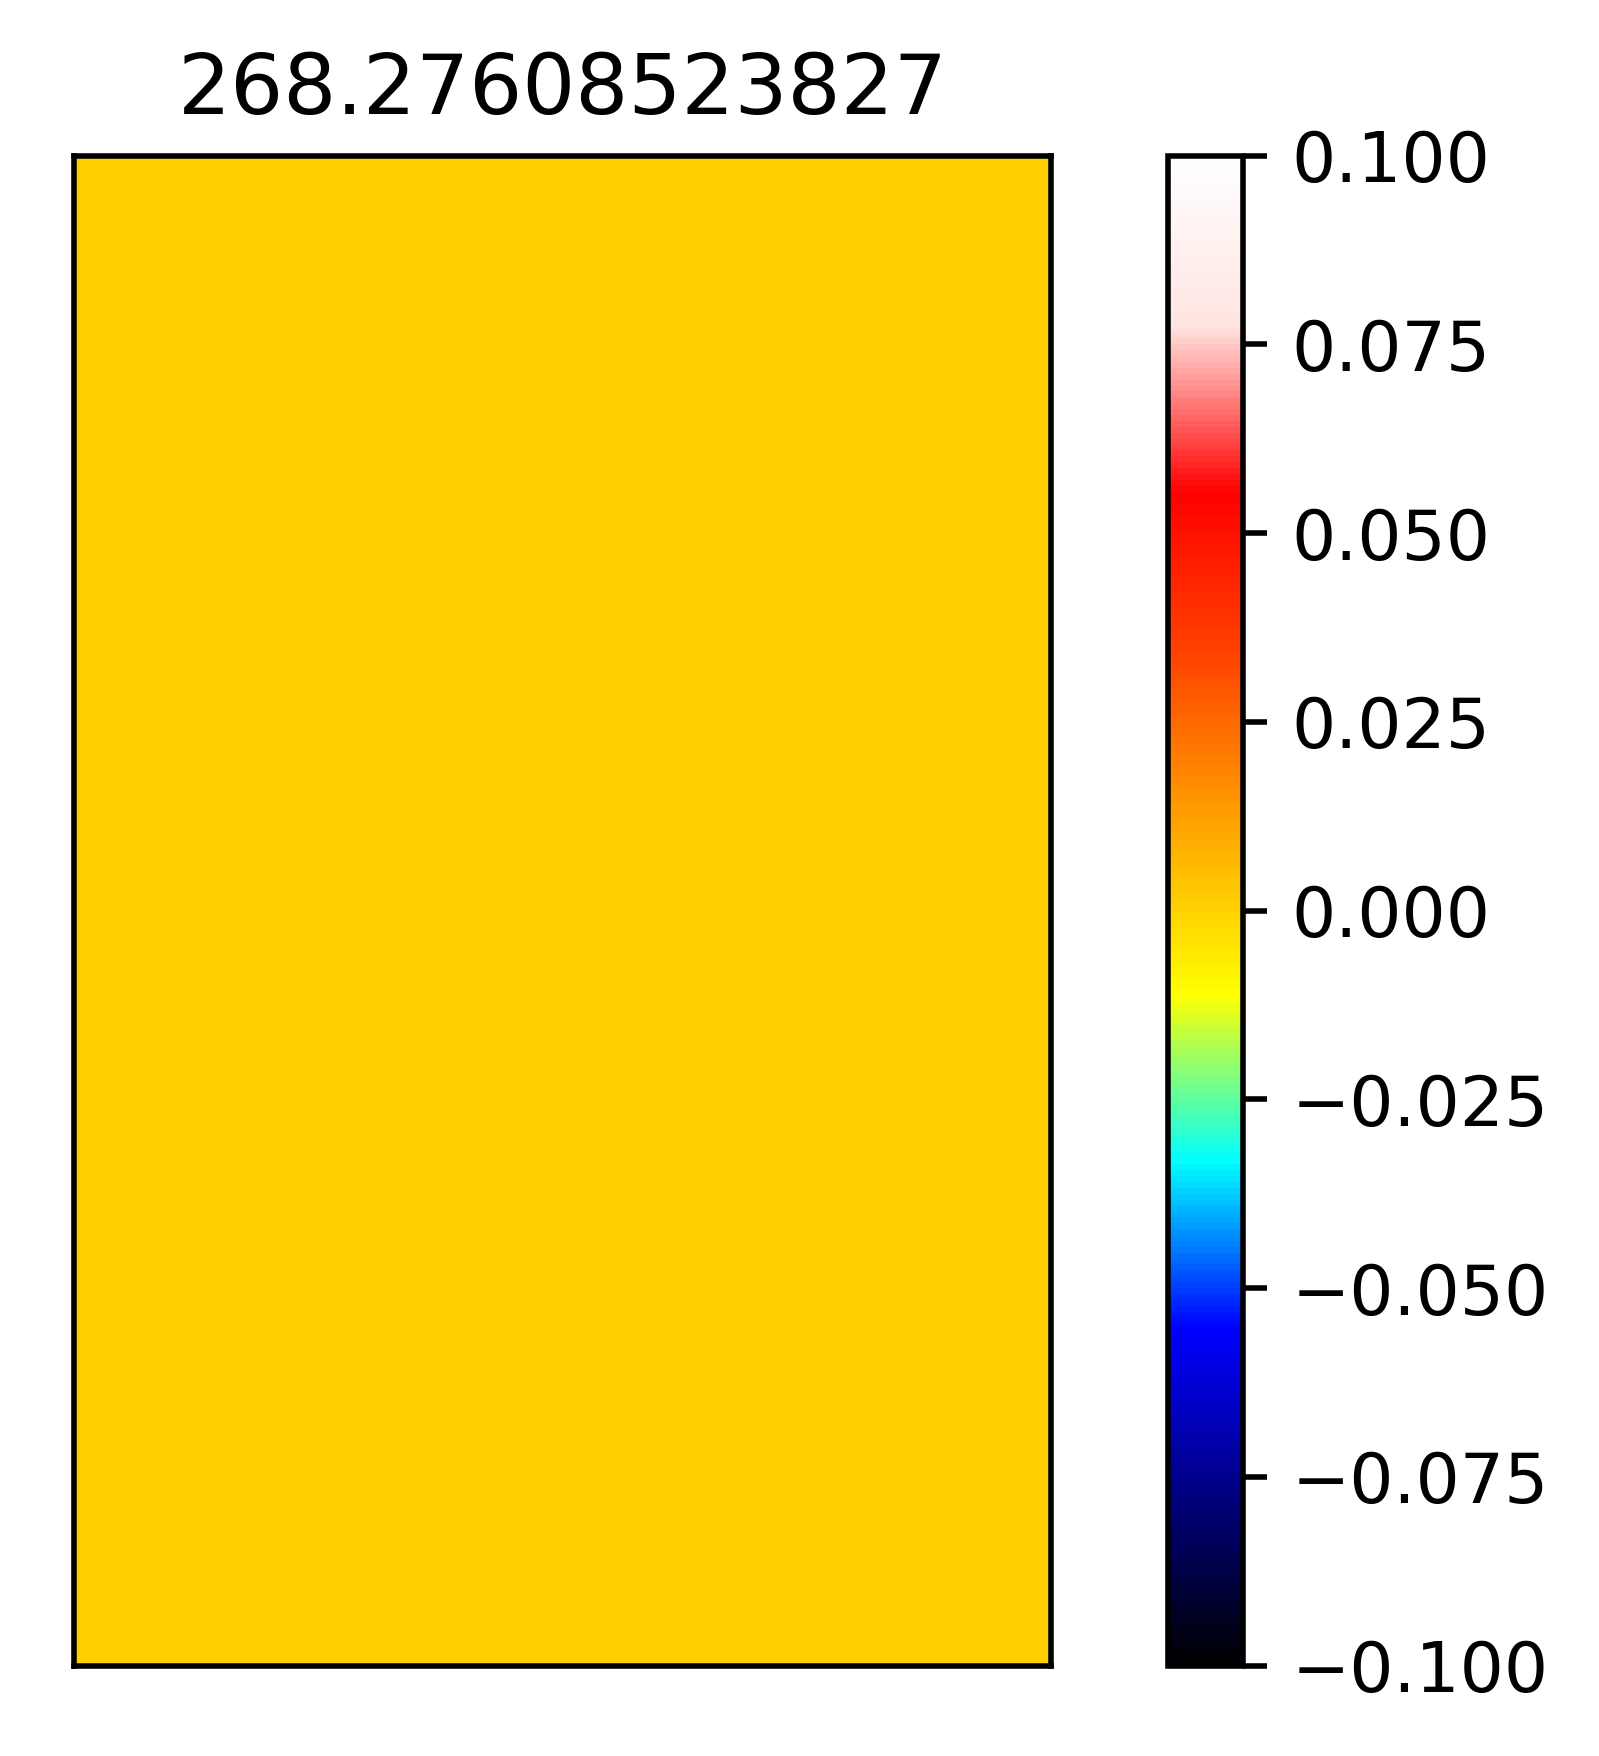

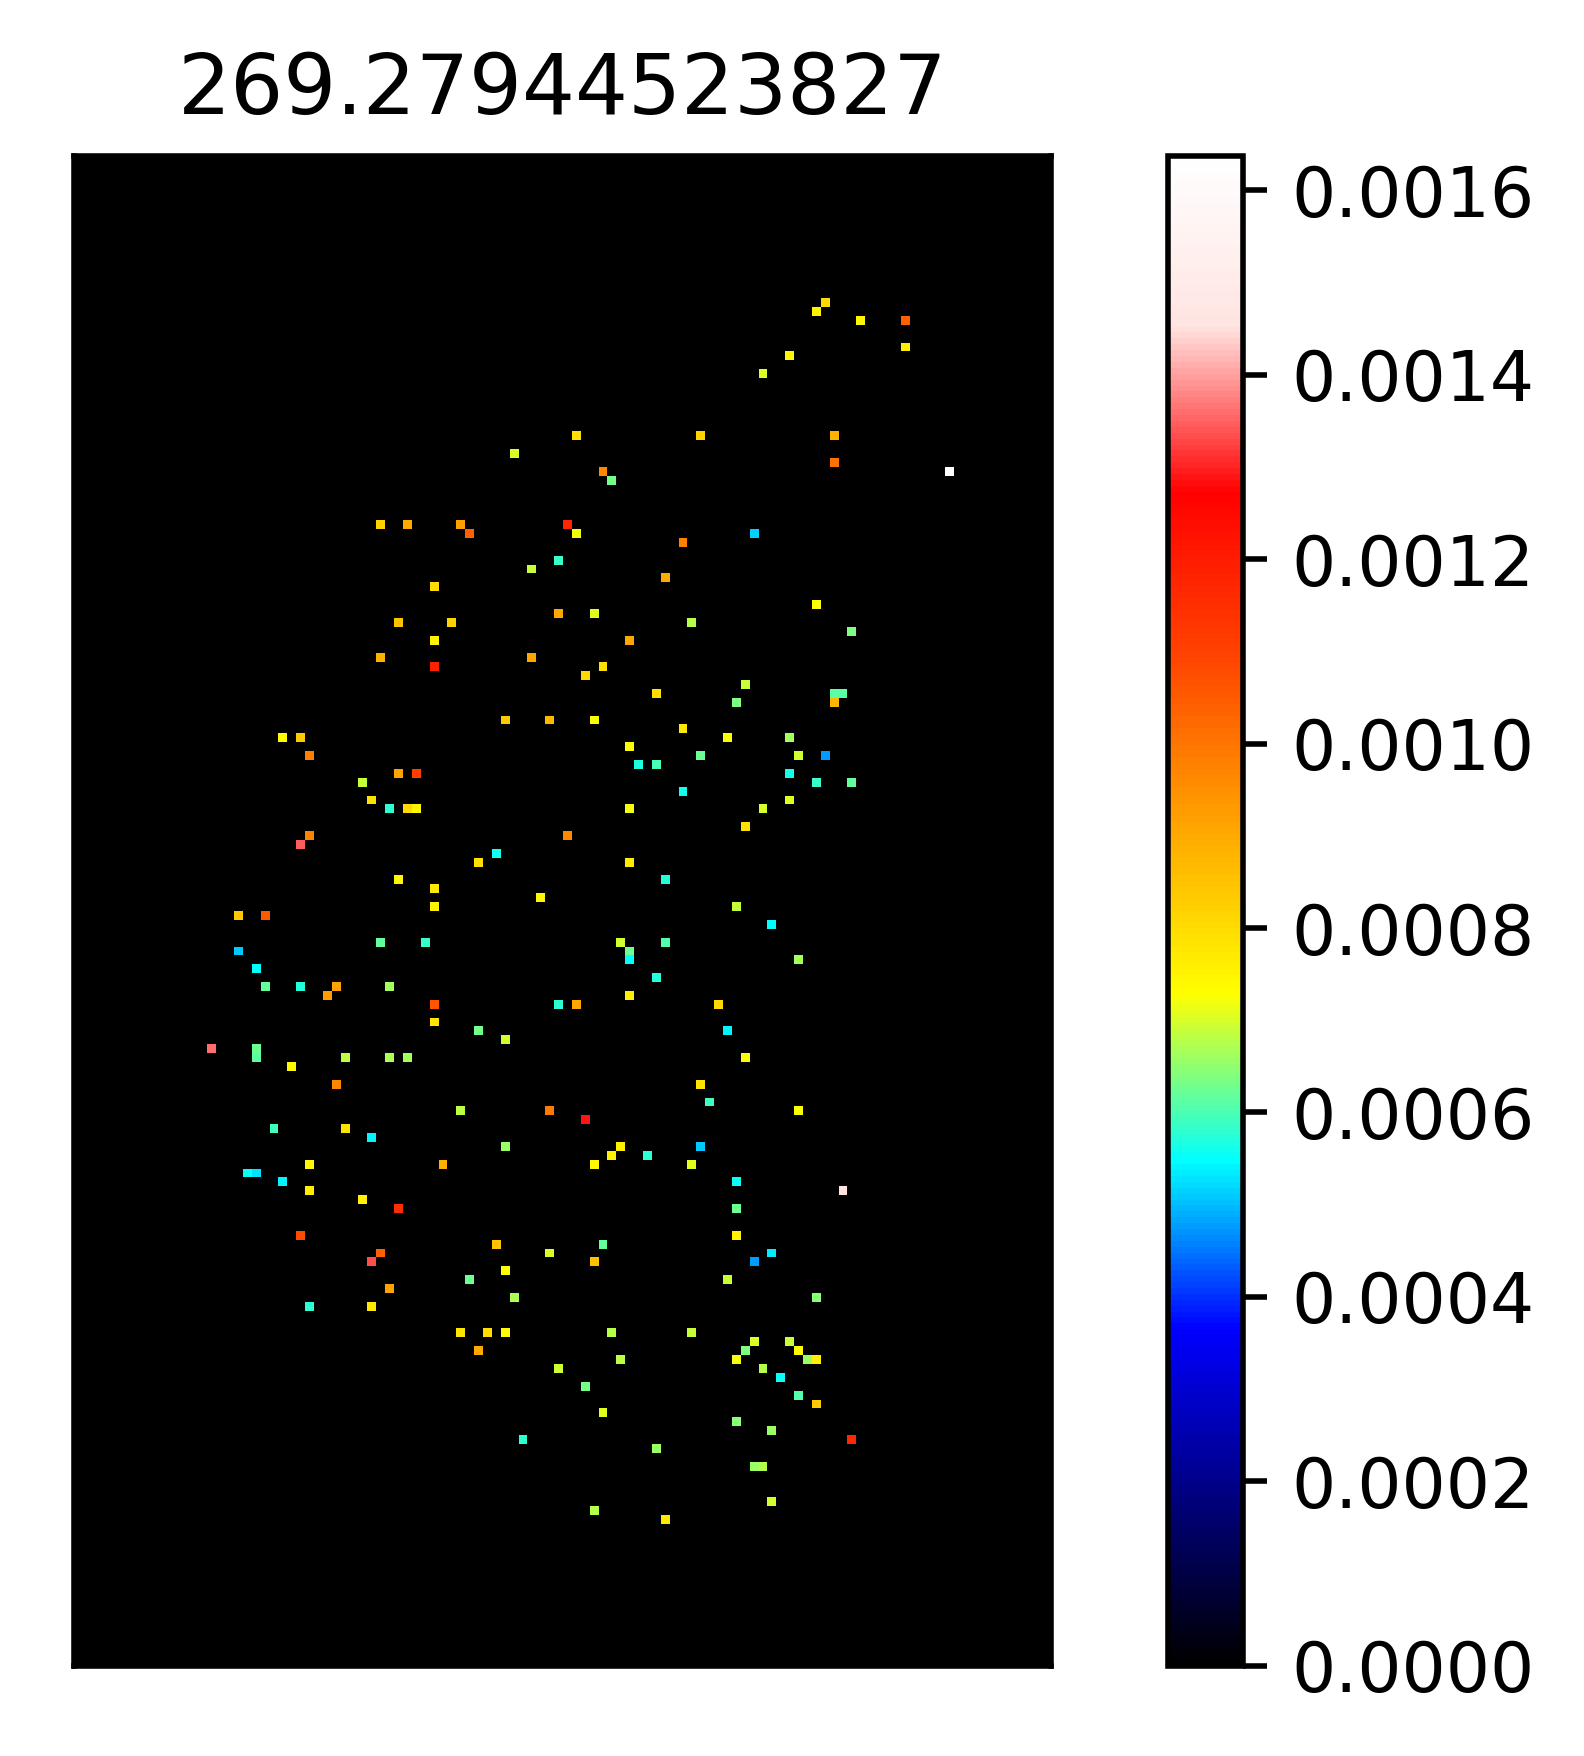

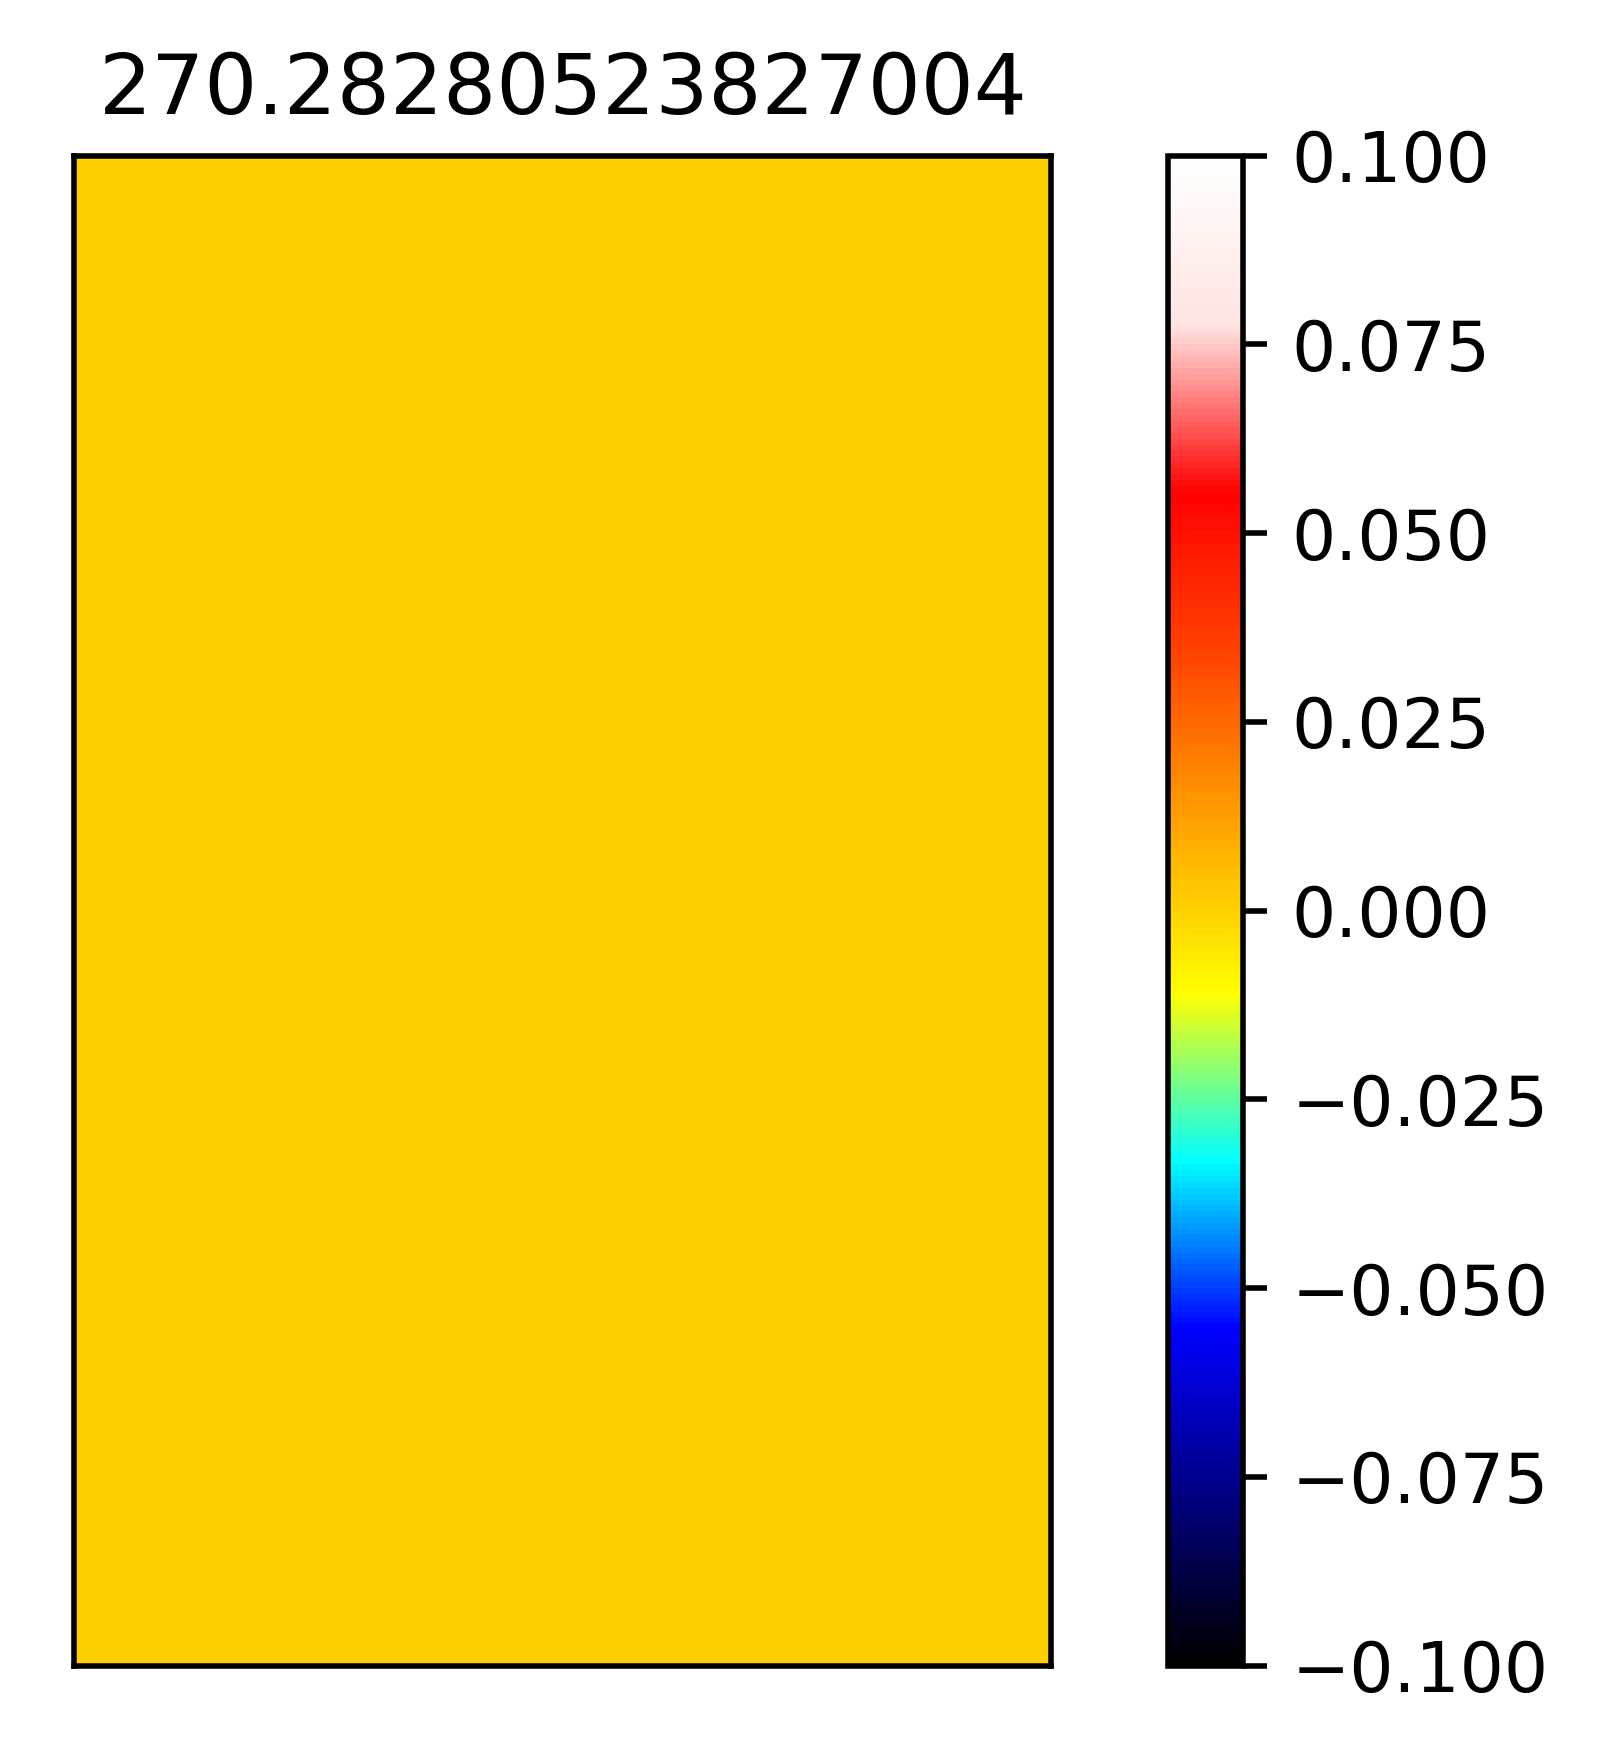

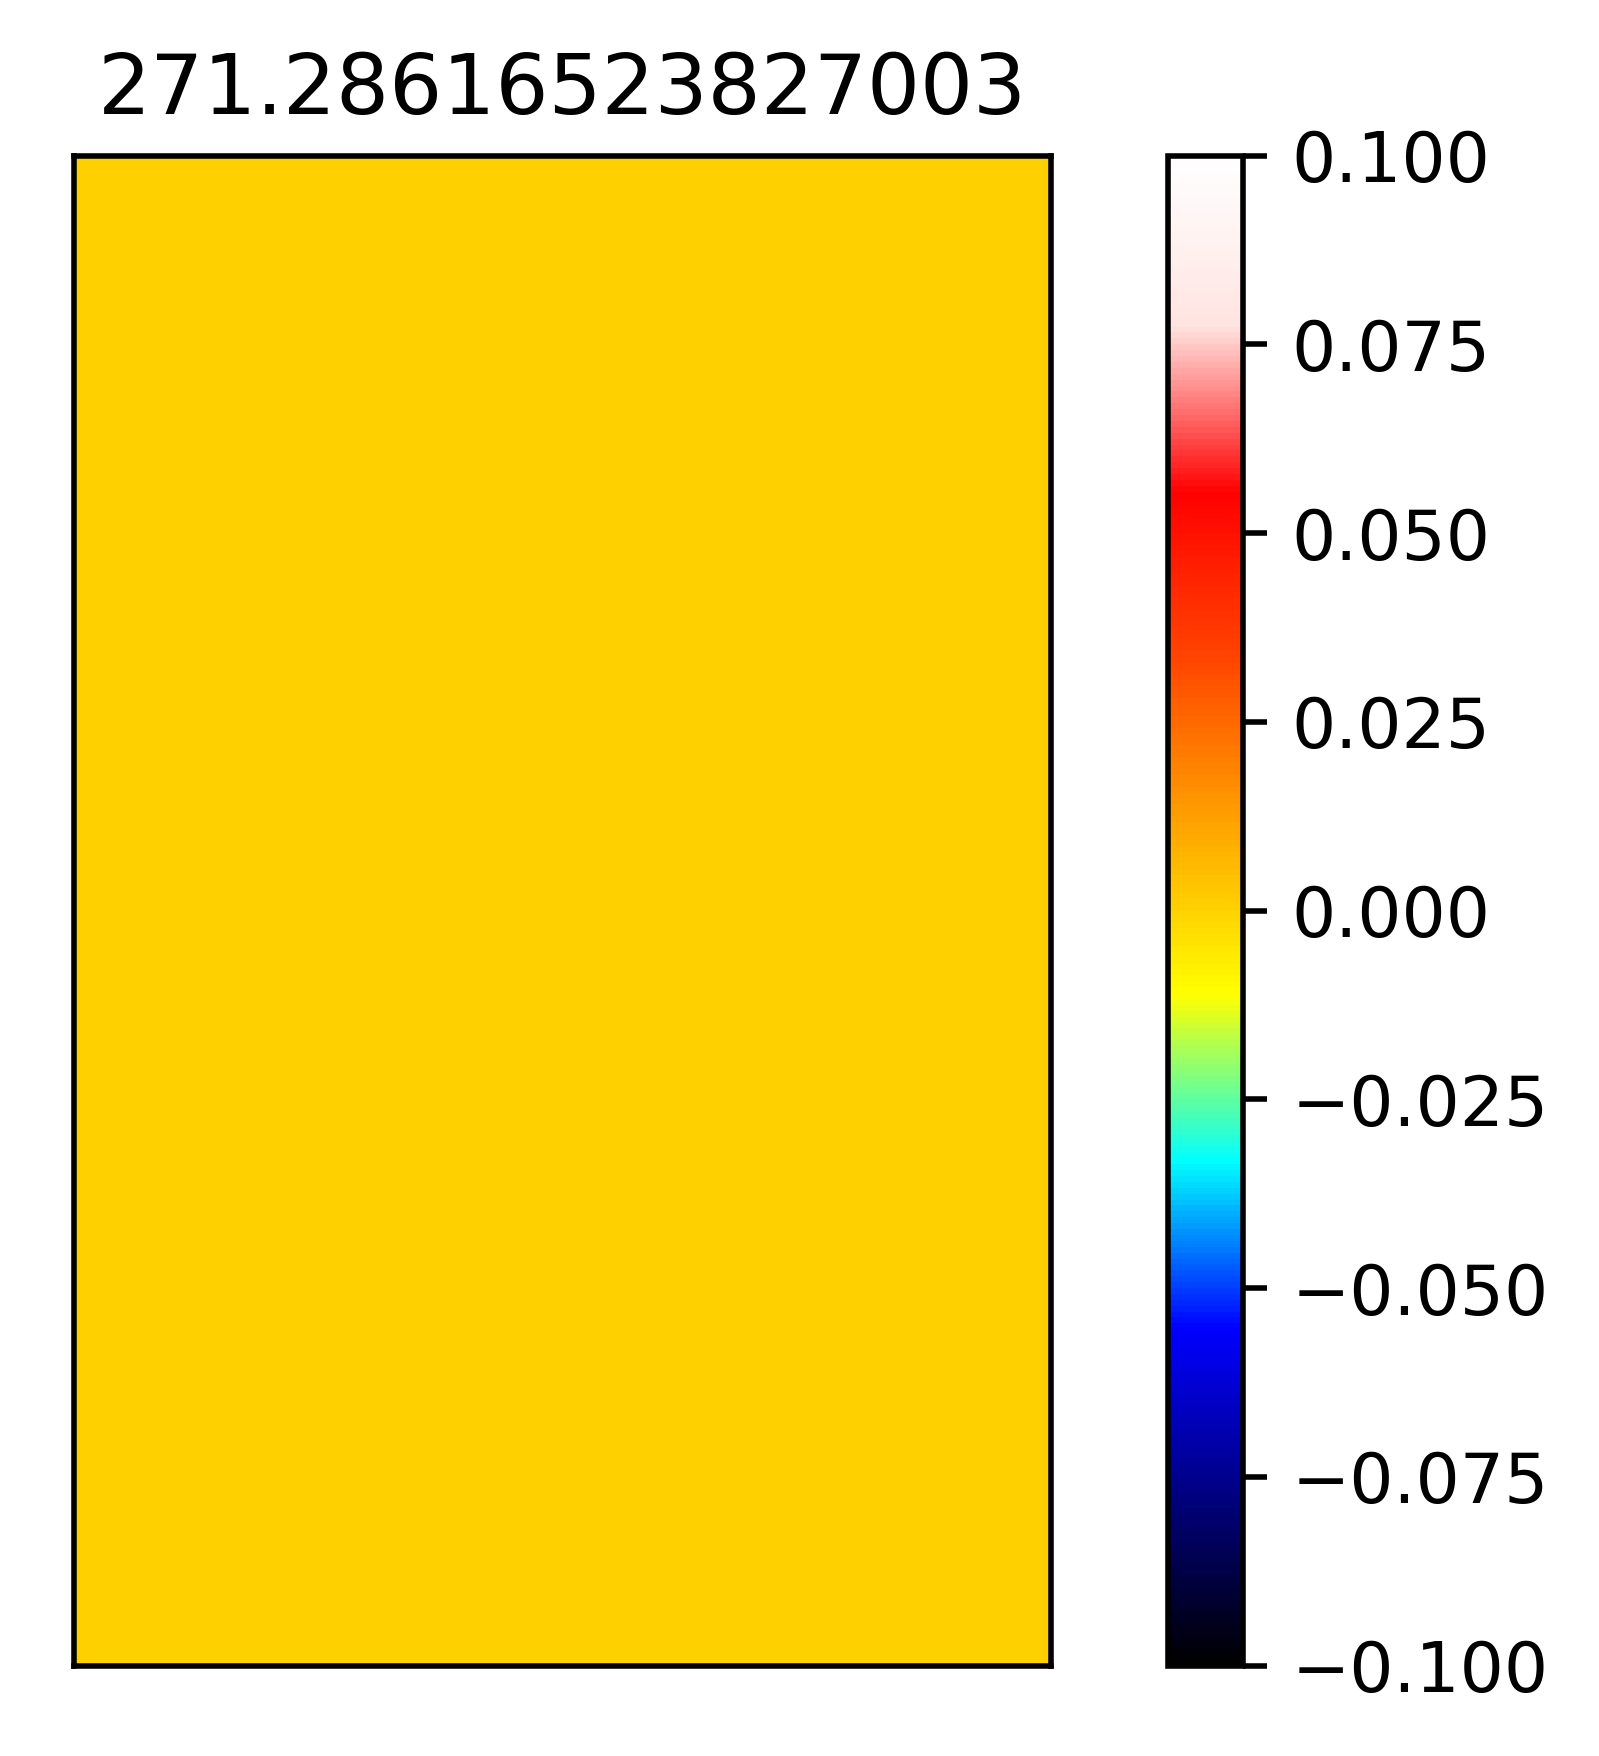

In [52]:
#calculation labeling pattern images and save result
goodInds = [x for x in range(len(msi.data_tensor)) if x not in []]

iso_tensor = SIMSIToolBox.normalizeTensor(msi.data_tensor[goodInds])
colormap = LinearSegmentedColormap.from_list("test",colors=["black", "navy","blue","cyan","yellow","orange","orangered","red","mistyrose","white"],N=256)

for mz,image in zip(np.array(msi.targets)[goodInds],iso_tensor):
    plt.figure()
    SIMSIToolBox.showImage(image,cmap=colormap)
    plt.title(mz)



In [53]:
patterns = []
for row in range(iso_tensor.shape[1]):
    for col in range(iso_tensor.shape[2]):
        if msi.imageBoundary[row,col] > 0.5:
            patterns.append(iso_tensor[:,row,col])
print(len(patterns))

10589


In [96]:
truePattern = isa_func(1.0,0.0,T,N,None)
print(truePattern)

[0.8378005971156914, 0.14909292729258006, 0.012436973206913907, 0.0006455321448819487, 2.3334453164337375e-05, 6.22881257369572e-07, 1.2701151355193497e-08, 2.0180942497057408e-10, 2.525168487371946e-12, 2.496515300401429e-14, 1.943697453295349e-16, 1.1791895571053684e-18, 5.464730842668963e-21, 1.87017311252574e-23, 4.457295443691276e-26, 6.61007750328332e-29, 4.5949729863572123e-32]


Text(0, 0.5, '# of pixels')

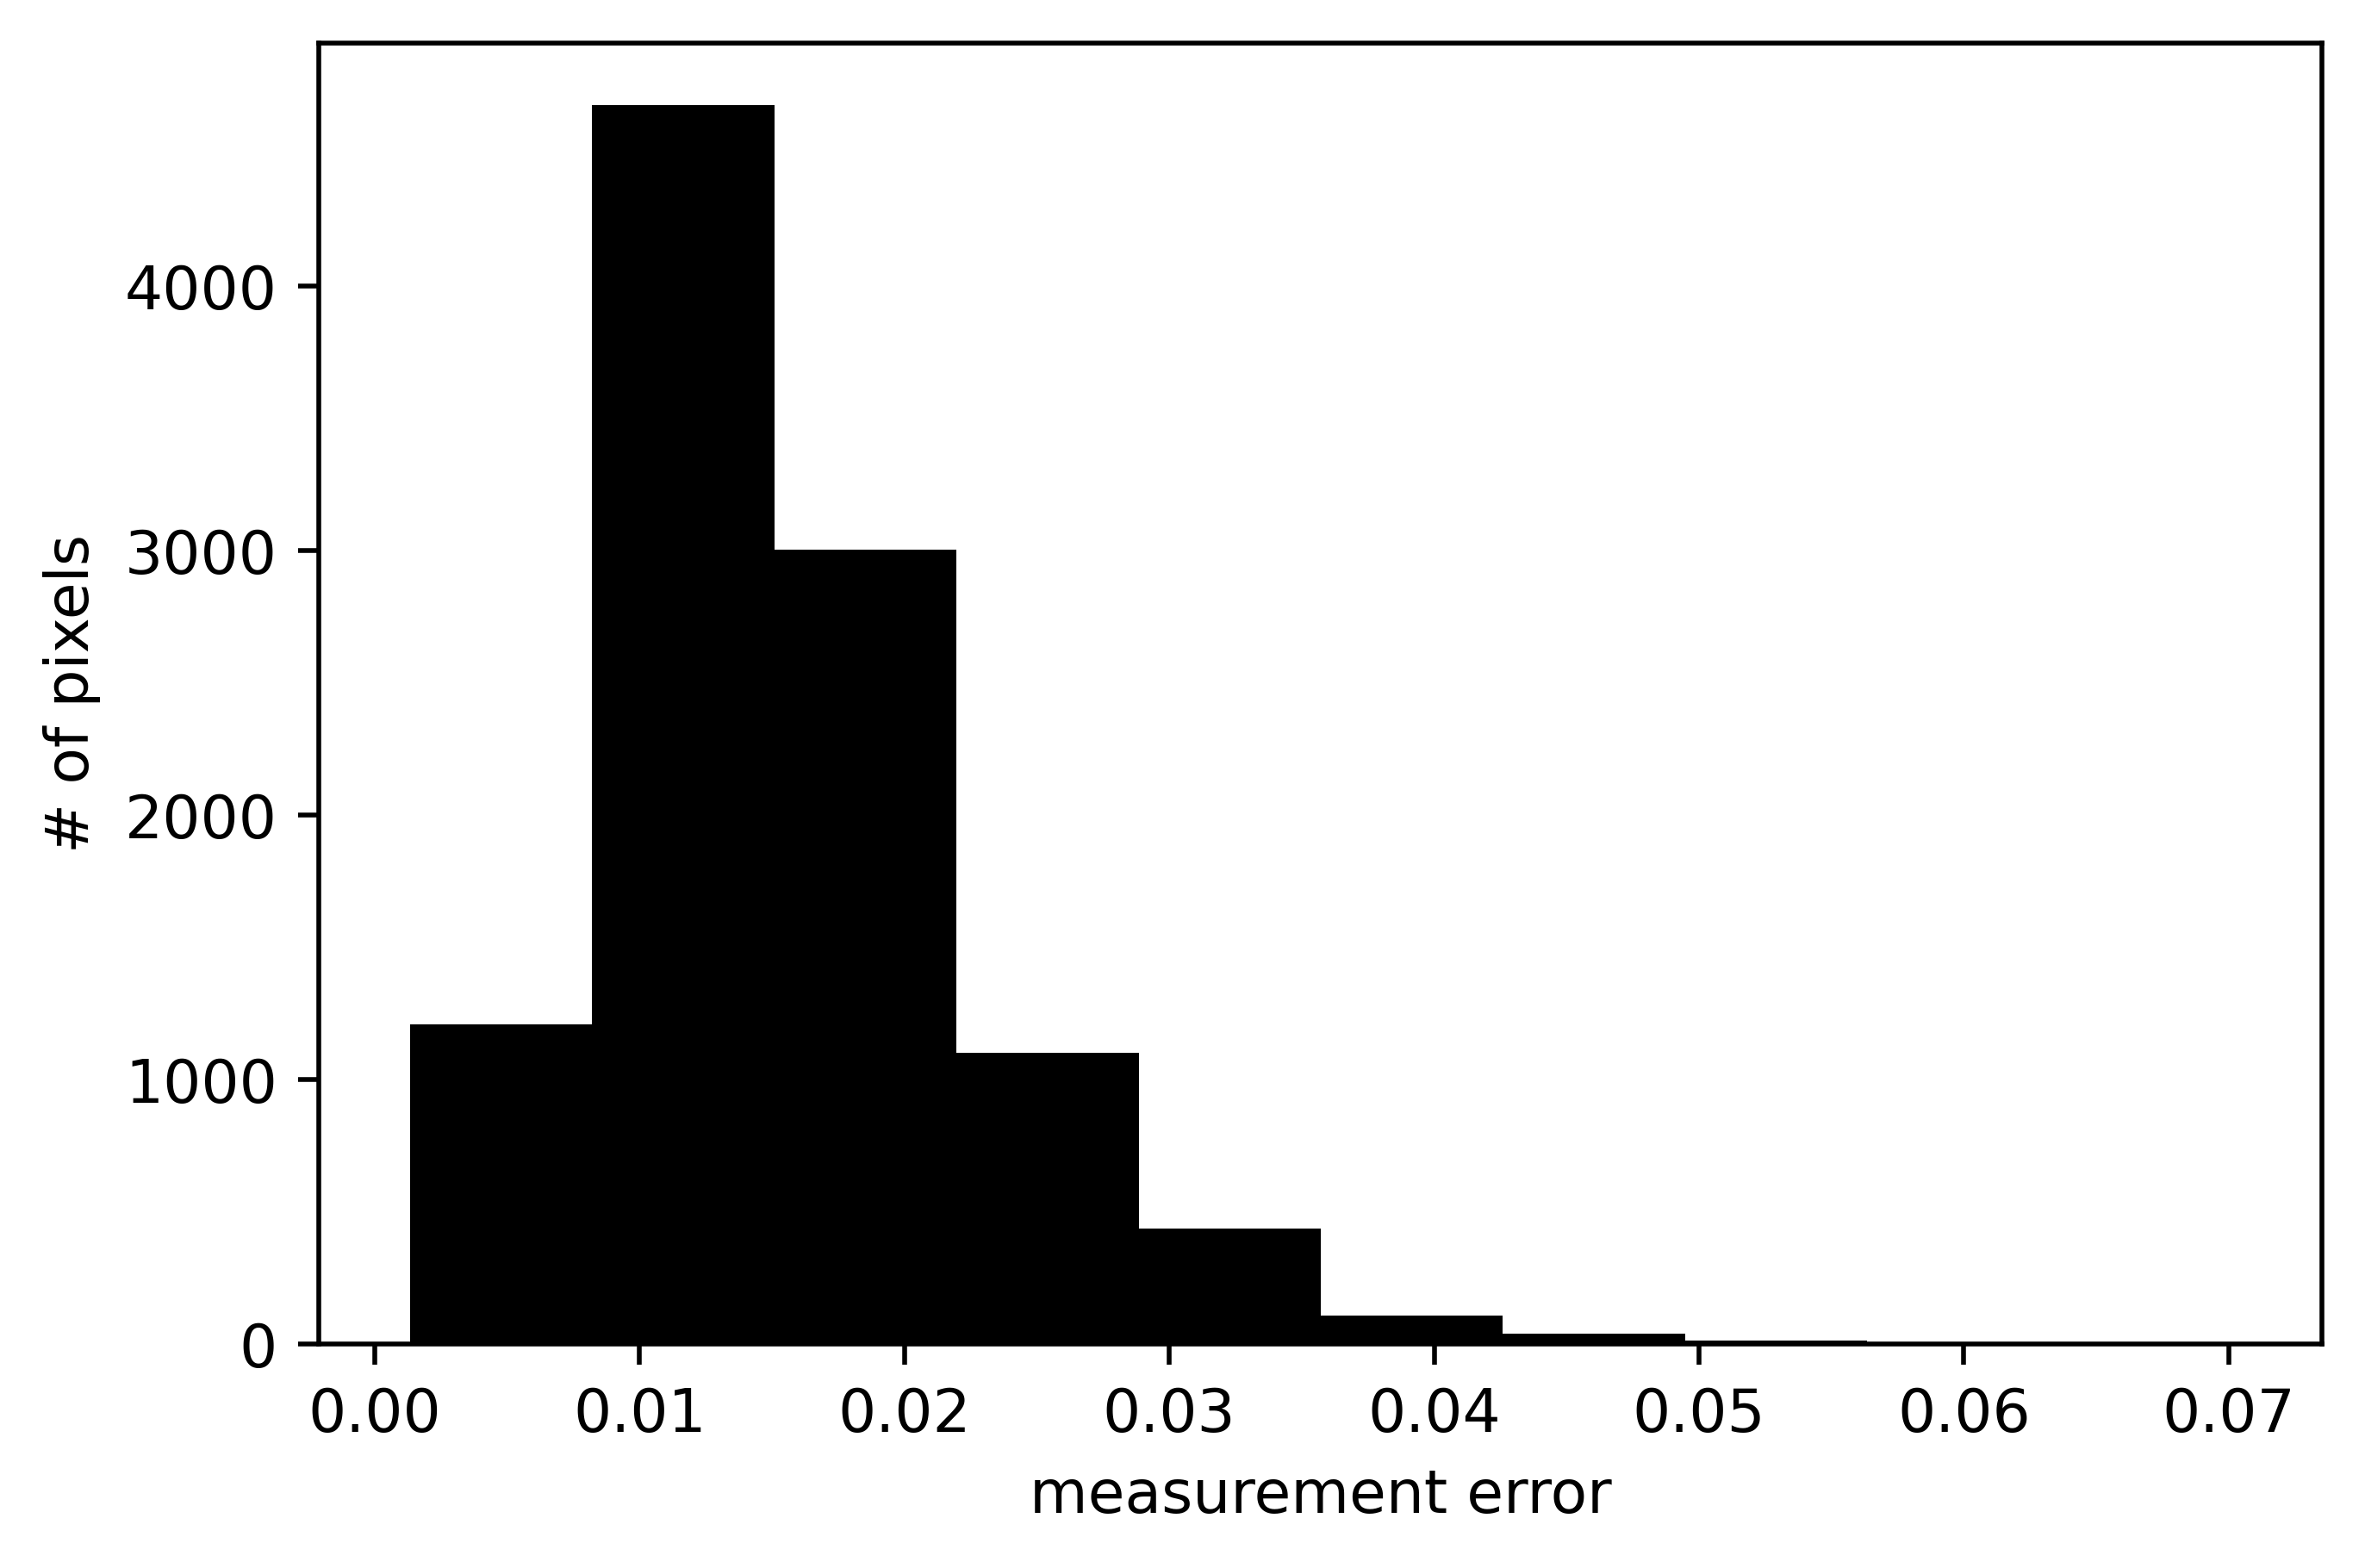

In [97]:
errs = []
for pattern in patterns:
    err_measure = np.sum([np.abs(x-y) for x,y in zip(pattern,truePattern)])
    errs.append(err_measure)
plt.hist(errs,color="black")
plt.xlabel("measurement error")
plt.ylabel("# of pixels")


Text(0, 0.5, '# of pixels')

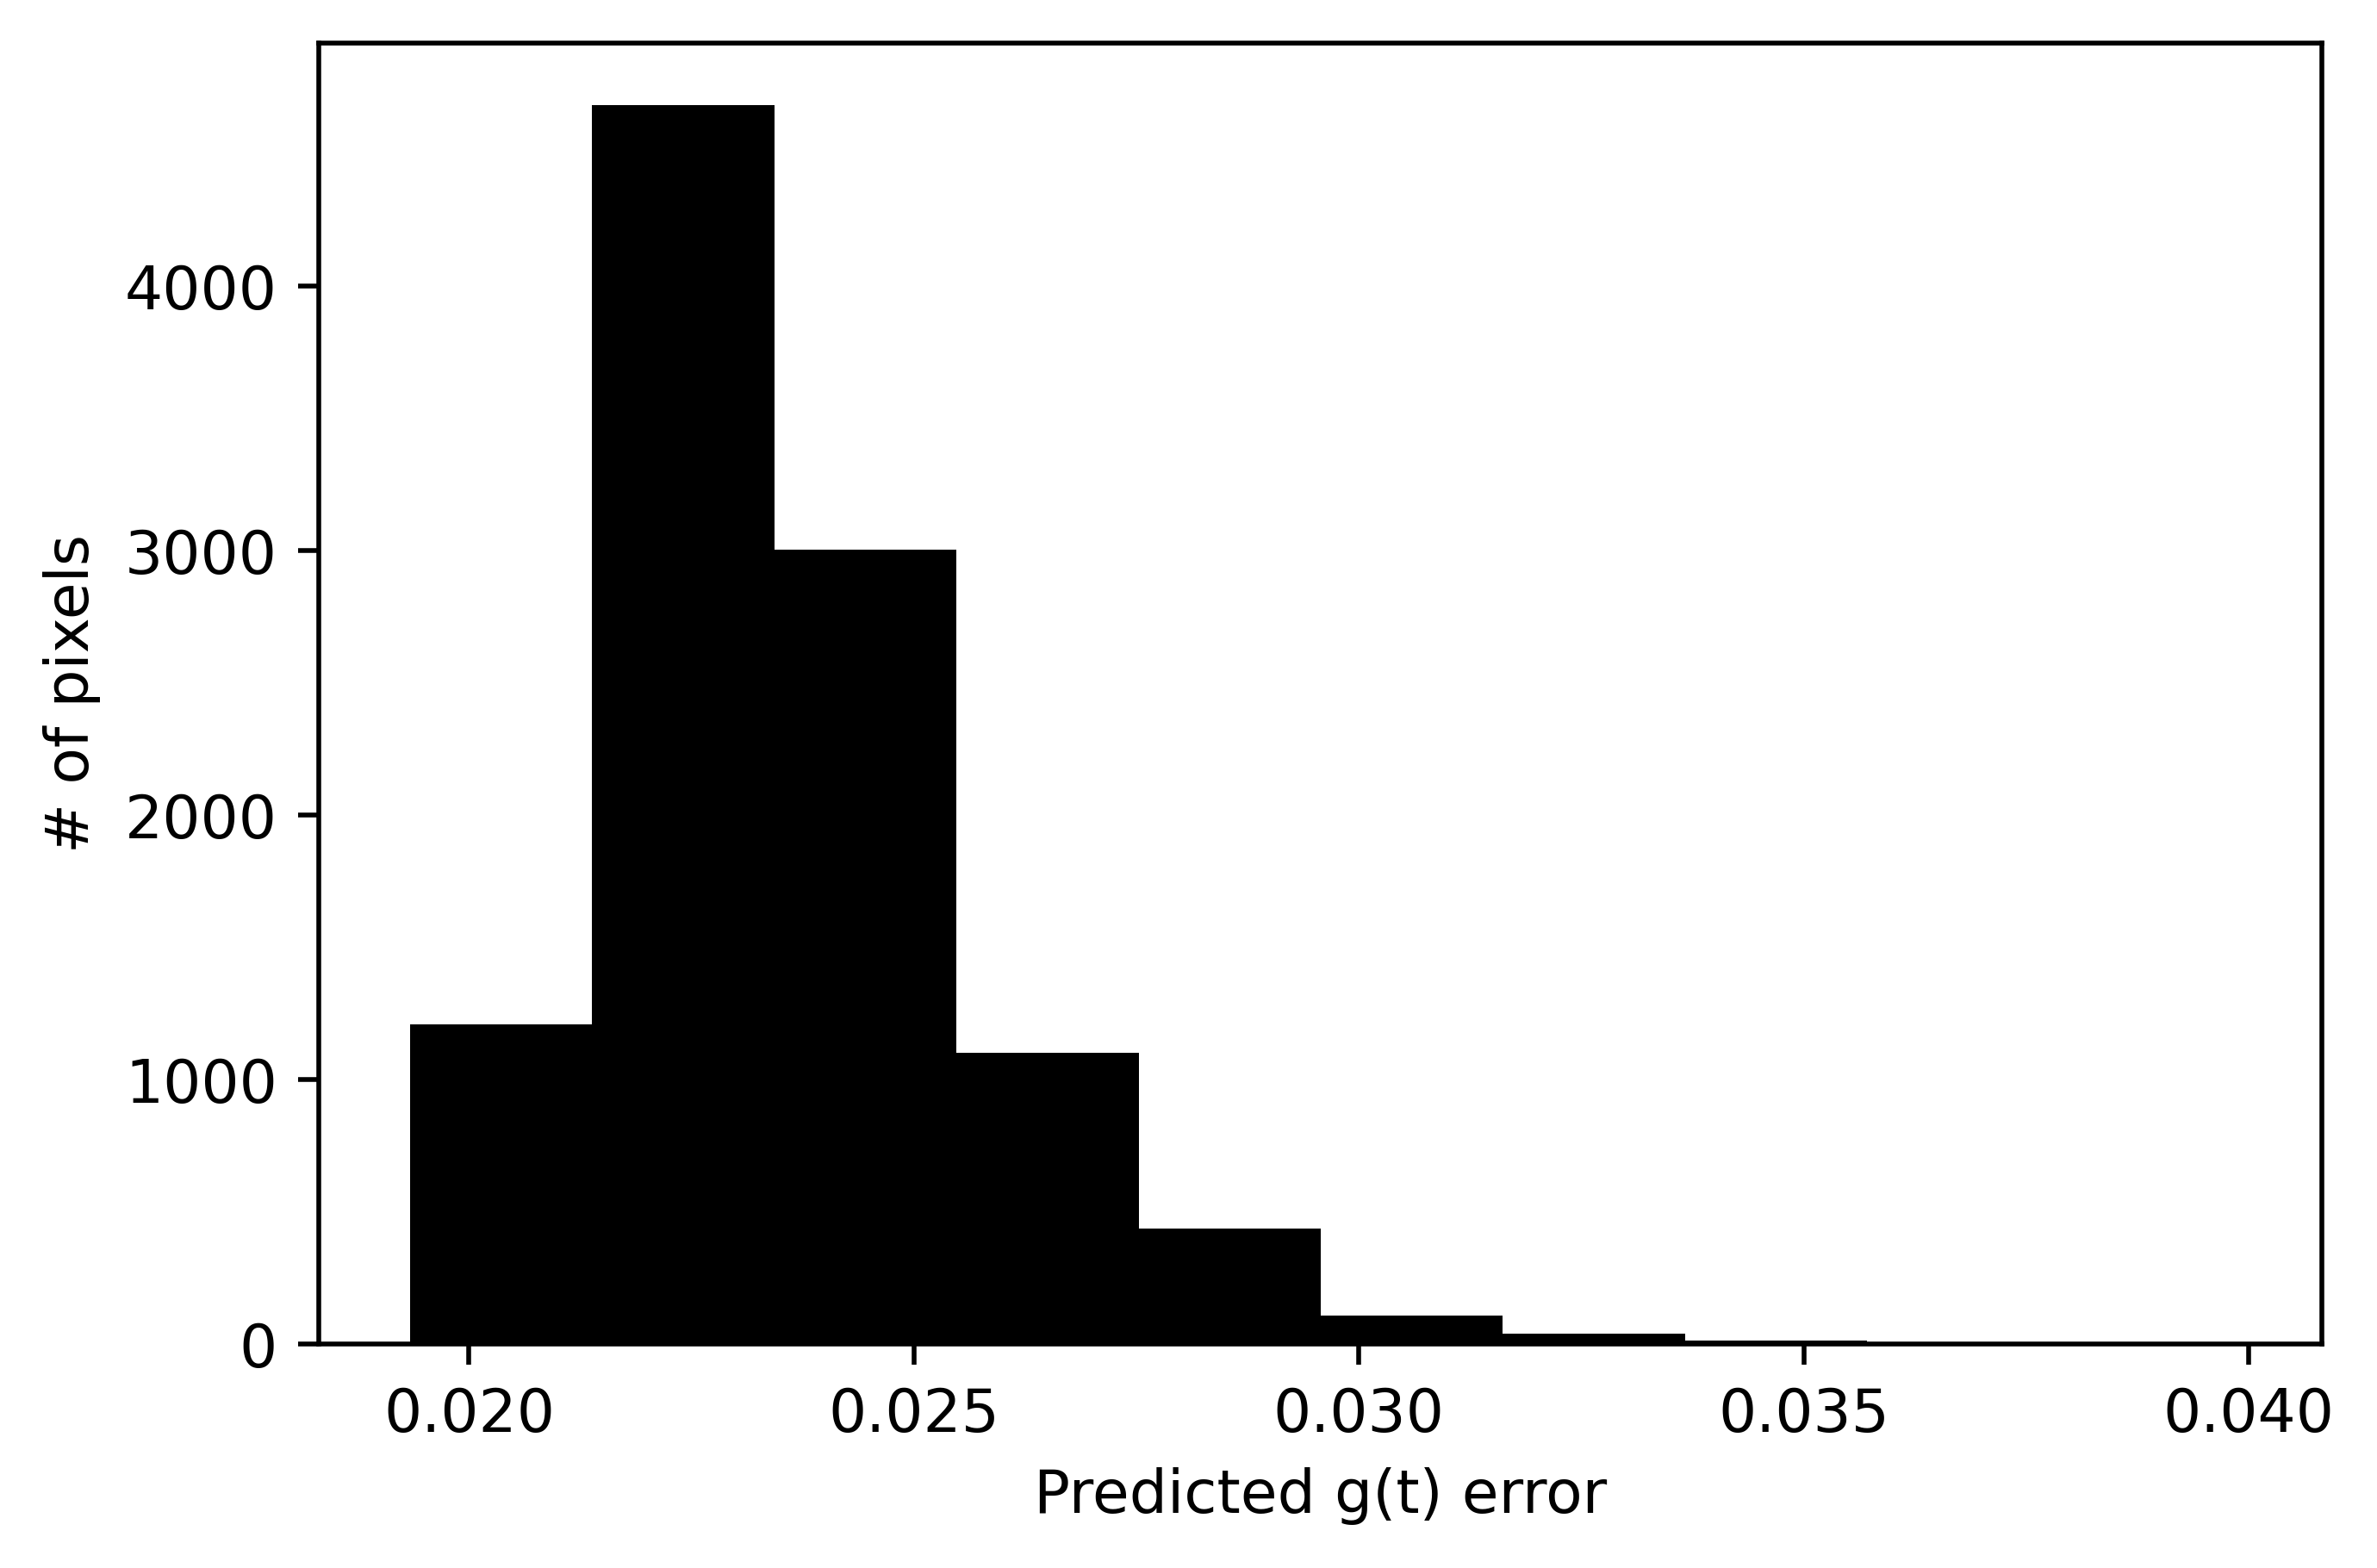

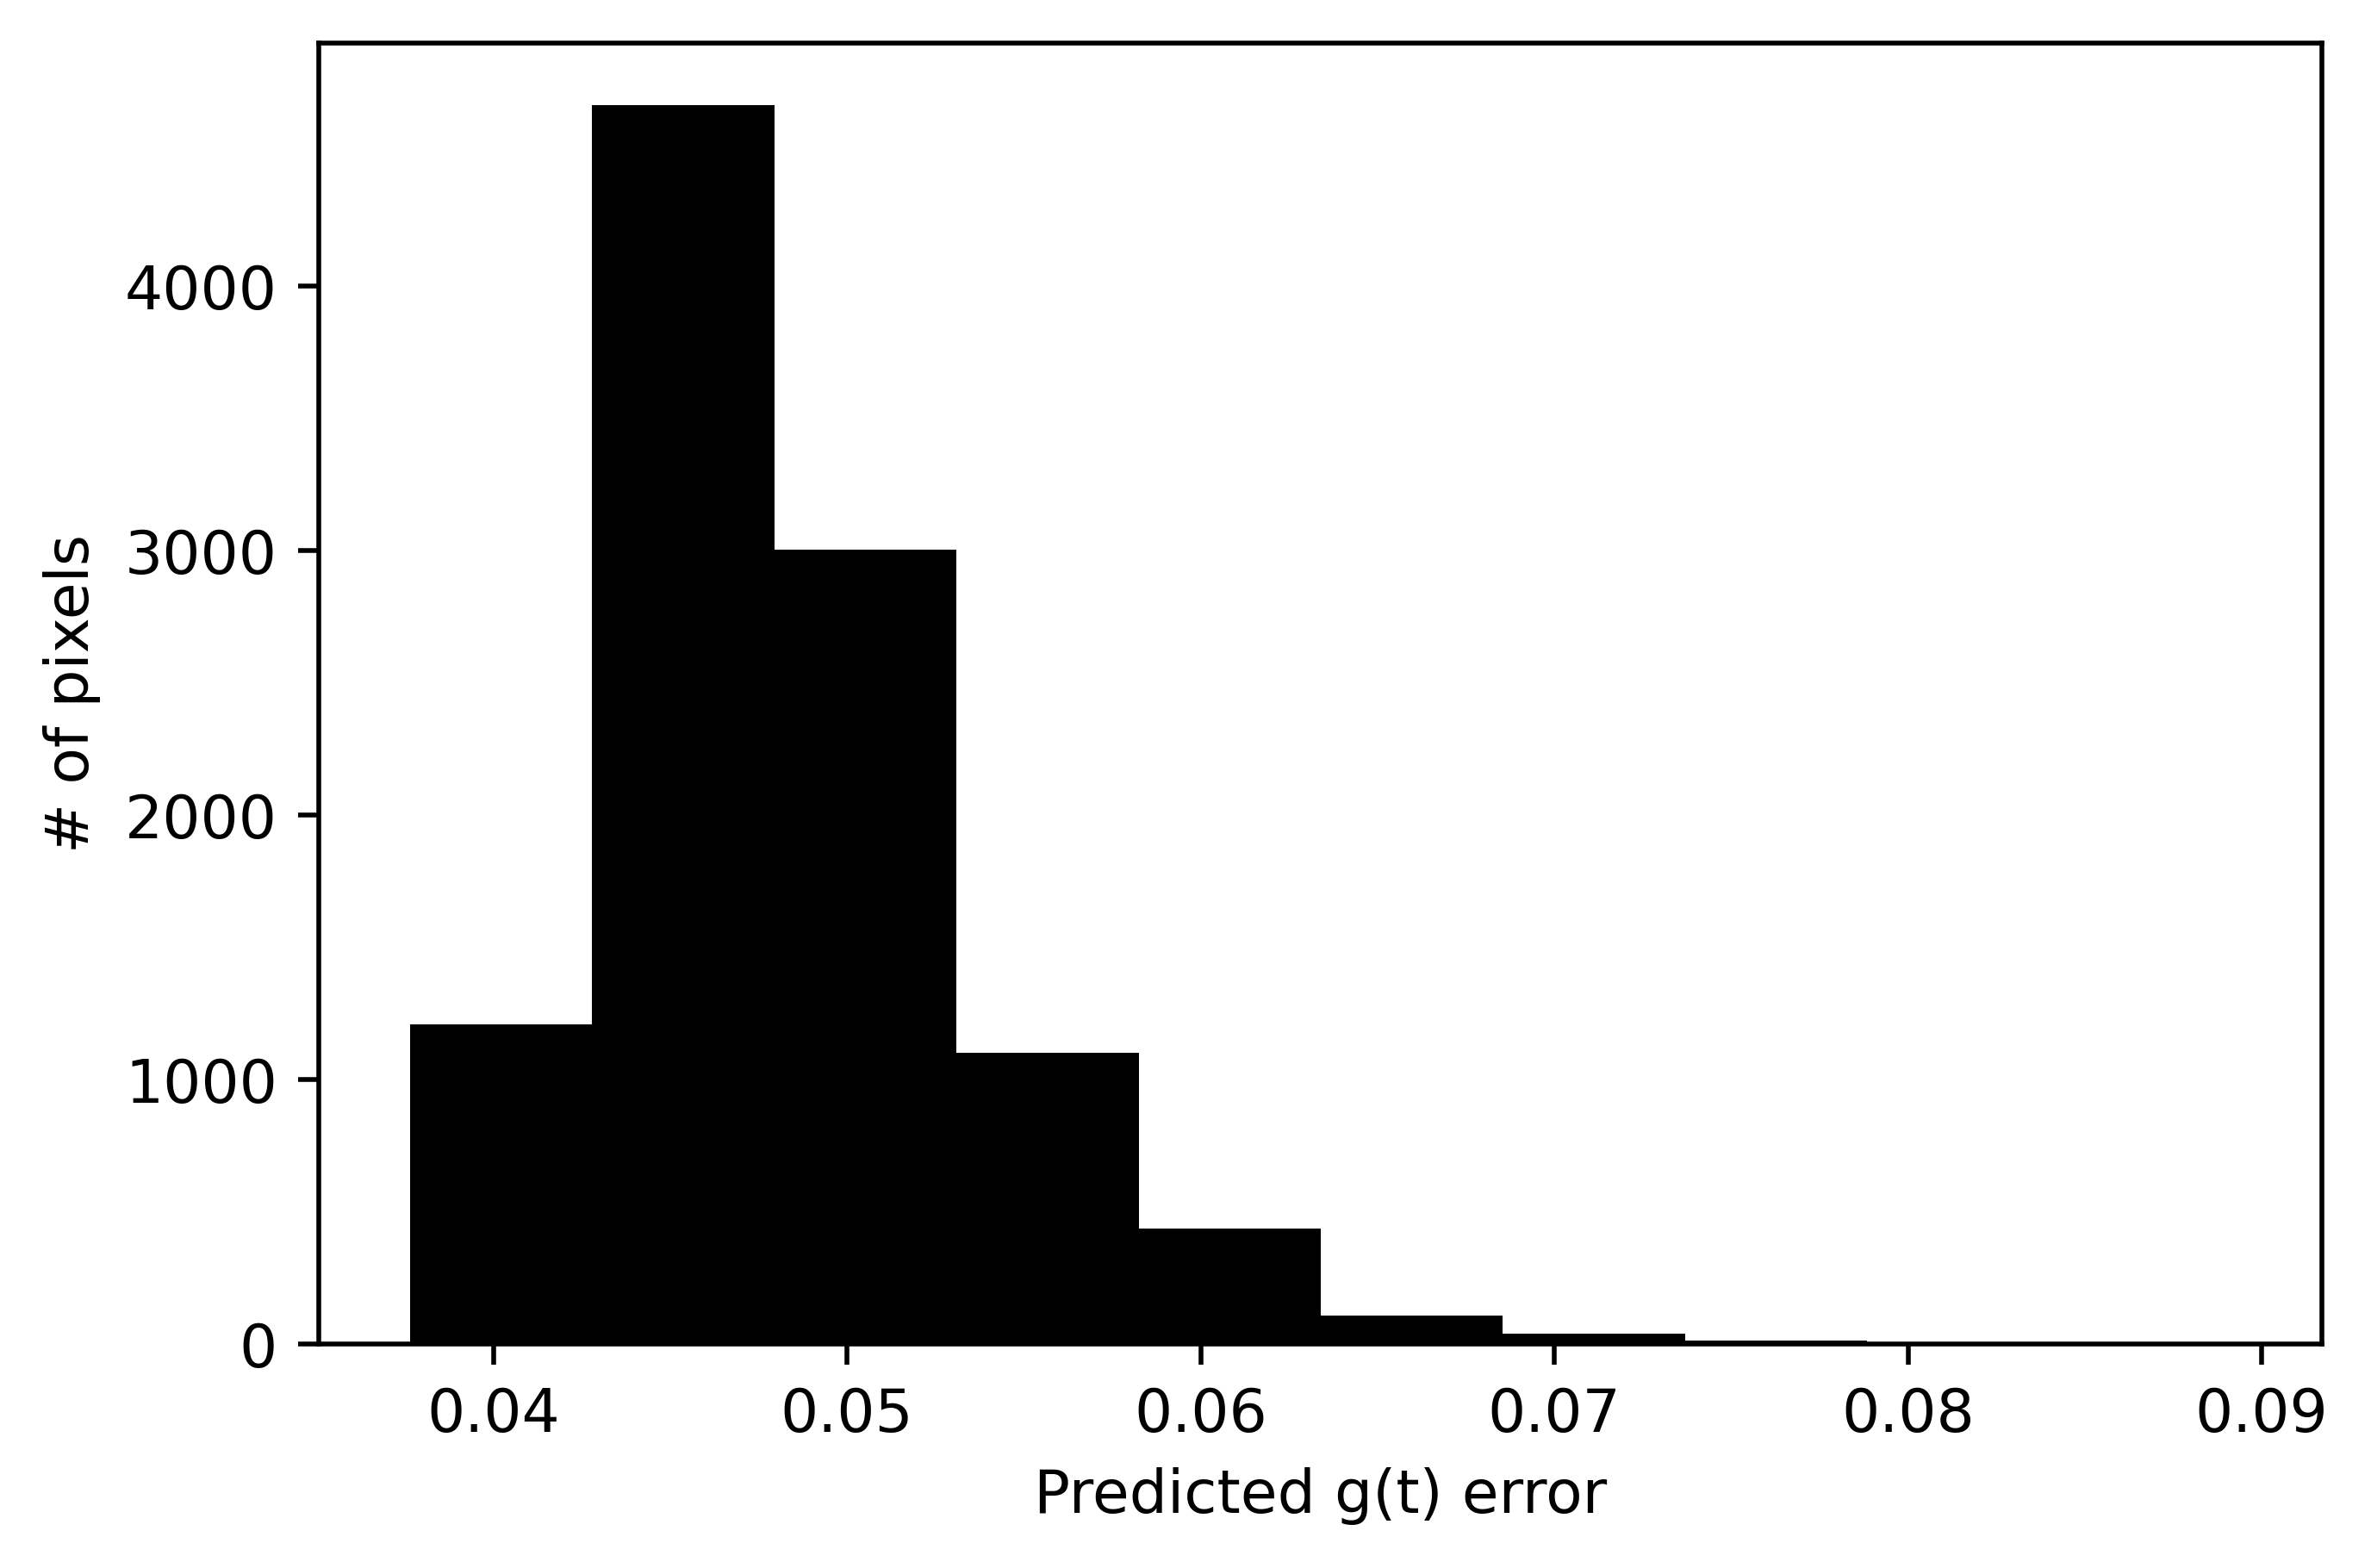

In [100]:
gerrs = []
xerrs = []
for err in errs:
    gerrs.append(models["error in g(t)"](err).tolist())
    xerrs.append(models["error in acetyl-CoA"](err).tolist())

plt.hist(gerrs,color="black")
plt.xlabel("Predicted g(t) error")
plt.ylabel("# of pixels")

plt.figure()
plt.hist(xerrs,color="black")
plt.xlabel("Predicted g(t) error")
plt.ylabel("# of pixels")
